In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import matplotlib.cm as cm
import arviz as az
#from sklearn.preprocessing import StandardScaler
import pytensor.tensor as pt
import matplotlib.cm as cm
#import regionmask
import cartopy.crs as ccrs
import pandas as pd
import seaborn as sns
import pytensor
from scipy.signal import detrend
import scipy.stats as stats
%matplotlib inline

In [2]:
savefigs=False

In [3]:
rng=np.random.default_rng(seed=123)

In [4]:
nada=xr.open_dataset("/Users/kmarvel/Documents/GEDA_BAYES/DATA/nada_hd2_cl.nc")
nada=nada.where(nada.pdsi>-90)

# Read in CRU TS 
Temperature, precipitation, PDSI from https://www.uea.ac.uk/web/groups-and-centres/climatic-research-unit/data

Accessed October 9, 2024

I want one array.  Time dimension is years.  PDSI is JJA average for that year.  T and P are the total for SOND (year before) and JFMAMJJA (that year)


In [5]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [6]:
def convert_timeaxis_years(X):
    return X.time.values.astype('datetime64[Y]').astype(int) + 1970

In [485]:
def latlon(location):
    dlatlon={}
    #Red Mesa, AZ
    dlatlon["RMA"]=(37.25,-109.25)
    #Dodge City, Kansas
    dlatlon["DCK"]=(37.75,-100.25)
    #Sonora Junction, California (Sierra Nevadas, near West Walk River, another hotspot of major drought activity)
    dlatlon["SJC"]=(38.25, -119.25)
    # Palm Springs (had a pluvial)
    dlatlon["PMS"]= (33.75,-116.75)
    return dlatlon[location]
    


def fullname(location):
    dn={}
    dn["RMA"]="Red Mesa, Arizona"
    dn["DCK"]="Dodge City, Kansas"
    dn["SJC"]="Sonora Junction, California"

def posterior_mean(X):
    return X.mean(dim=("chain","draw"))

In [8]:
class OBS():
    def __init__(self,data=None):
        if data is not None:
            self.data=data
        else:
            #read in cru from datasets
            cru_t=xr.open_dataset("/Users/kmarvel/Documents/Reconstruction/DATA/cru_ts4.08.1901.2023.tmp.dat.nc")
            cru_p=xr.open_dataset("/Users/kmarvel/Documents/Reconstruction/DATA/cru_ts4.08.1901.2023.pre.dat.nc")
            cru_d=xr.open_dataset("/Users/kmarvel/Documents/Reconstruction/DATA/scPDSI.cru_ts4.08early1.1901.2023.cal_1901_23.bams.2024.GLOBAL.IGBP.WHC.1901.2023.nc")
            #select NADA region
            t_nada=cru_t.sel(lat=nada.lat,lon=nada.lon)
            p_nada=cru_p.sel(lat=nada.lat,lon=nada.lon)
            d_nada=cru_d.sel(latitude=nada.lat,longitude=nada.lon)

            ##### SUMMER PDSI #####
            seasonal_d = d_nada.resample(time='QS-DEC').mean('time')
            # get rid of the first JJA because we won't have September-December the year before
            jja_pdsi=seasonal_d.isel(time=np.arange(len(seasonal_d.time))[2::4]).isel(time=slice(1,None))
            PDSI=jja_pdsi.scpdsi
            

            ##### SEP-AUG PRECIPITATION#####
            # I hate time axes, why is this such a nightmare
            years=[x.astype('M8[Y]').astype(int) + 1970 for x in PDSI.time.values]
            months=["SEP","OCT","NOV","DEC","JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG"]
            firstyear=years[0]
            lastyear=years[-1]
            truncated=p_nada.pre.sel(time=slice(str(firstyear-1)+"-09-01",str(lastyear)+"-08-31"))
            newcoords={}
            newcoords["lon"]=truncated.coords["lon"]
            newcoords["lat"]=truncated.coords["lat"]
            newcoords["year"]=years
            newcoords["month"]=months
            ntime,nlat,nlon=truncated.values.shape
            nyears=int(ntime/12)
            reshaped_data=truncated.values.reshape(nyears,12,nlat,nlon)
            PRECIP=xr.DataArray(data=reshaped_data,dims=("year","month","lat","lon"),coords=newcoords)

             ##### SEP-AUG TEMPERATURE #####
            truncated=t_nada.tmp.sel(time=slice(str(firstyear-1)+"-09-01",str(lastyear)+"-08-31"))
            newcoords={}
            newcoords["lon"]=truncated.coords["lon"]
            newcoords["lat"]=truncated.coords["lat"]
            newcoords["year"]=years
            newcoords["month"]=months
            ntime,nlat,nlon=truncated.values.shape
            nyears=int(ntime/12)
            reshaped_data=truncated.values.reshape(nyears,12,nlat,nlon)
            TEMP=xr.DataArray(data=reshaped_data,dims=("year","month","lat","lon"),coords=newcoords)

            self.data={}
            self.data["T"]=TEMP
            self.data["P"]=PRECIP
            self.data["D"]=PDSI
            
  

In [9]:
def get_seasonal(lat,lon,vari):
    X=cru.data[vari].sel(lat=lat,lon=lon)
    X_son=X.sel(month=["SEP","OCT","NOV"]).mean(dim="month").expand_dims({"season":["SON"],"vari":[vari]})
    X_djf=X.sel(month=["DEC","JAN","FEB"]).mean(dim="month").expand_dims({"season":["DJF"],"vari":[vari]})
    X_mam=X.sel(month=["MAR","APR","MAY"]).mean(dim="month").expand_dims({"season":["MAM"],"vari":[vari]})
    X_jja=X.sel(month=["JUN","JUL","AUG"]).mean(dim="month").expand_dims({"season":["JJA"],"vari":[vari]})
    seasonal=xr.concat([X_son,X_djf,X_mam,X_jja],dim="season")
    return seasonal 

In [10]:
cru=OBS()

In [14]:
gistemp_data=pd.read_csv("https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv",header=1)
gistemp_data["J-D"]
gistemp=xr.DataArray(data=gistemp_data["J-D"].values[:-1].astype(np.float32),\
                     dims=("year"),\
                     coords={"year":gistemp_data["Year"].values[:-1]}).rename("tas")

In [15]:
### Define a helper function that will construct our vector autoregressive step for the marginal contribution of each previous
### term in each of the respective time series equations
def calc_var_step(lag_coefs, dataset):
    n_vars, n_cross,n_lags=lag_coefs.shape#.eval()
    ars = []
    for k in range(len(coords["vari"])):
        ar_cross=[]
        for j in range(len(coords["cross_vari"])):
            ar_lags=[]
            for i in range(nlags):
                ar_lags.append(lag_coefs[k,j,i]* dataset[j,(i+1):])
            sum_lags=pm.math.sum(ar_lags,axis=0)
            
            ar_cross.append(sum_lags)
        sum_cross=pm.math.sum(ar_cross,axis=0)
        ars.append(sum_cross)
    return pm.math.stack(ars,axis=-1)
 

In [625]:
# Option to regress over tue full LMR
fname="../DATA/LMR/gmt_MCruns_ensemble_full_LMRv2.1.nc"
vname=None
def open_lmr(fname,vname=None):
        
    ds=xr.open_dataset(fname,decode_times=False)
    if vname is None:
        vname=list(ds.data_vars.keys())[0]
    data=getattr(ds,vname)
    yrs=data.time.values/365
    data=data.rename({"time":"year"})
    data["year"]=lmryears
    return data
G_lmr=open_lmr(fname)


In [712]:
G=xr.DataArray(data=gistemp_data["JJA"].values[:-1].astype(np.float32),\
             dims=("year"),\
             coords={"year":gistemp_data["Year"].values[:-1]}).rename("tas")
np.average(G.values[:30])

np.float32(-0.23766667)

In [725]:
class Reconstructor_new():
    def __init__(self,\
                 region,
                 training_period=(1950,2005),\
                 validation_period=(1902,1949),\
                reconstruction_period=(1000,1901),
                use_paleo_G=False):
        
        self.training_period=training_period
        self.validation_period=validation_period
        self.reconstruction_period=reconstruction_period
        self.region=region
        self.use_paleo_G=use_paleo_G
        
        
        lat,lon=latlon(self.region)
        
        self.lat=lat
        self.lon=lon
        
        T= cru.data["T"].sel(lat=lat,lon=lon).expand_dims({"vari":["T"]})
        P= cru.data["P"].sel(lat=lat,lon=lon).expand_dims({"vari":["P"]}) 
        Dcru= cru.data["D"].assign_coords({"time":cru.data["T"].year.values}).rename({"time":"year"}).\
            sel(lat=lat,lon=lon).expand_dims({"vari":["D"]}).sel(vari="D")
       
            #M=xr.concat([T.expand_dims({"vari":["T"]}),P.expand_dims({"vari":["P"]})],dim="vari")  
        
        #normalize both
        #T is assumed normally distributed
        muT=T.sel(year=slice(*self.training_period)).mean(dim="year")
        sigT=T.sel(year=slice(*self.training_period)).std(dim="year")
        Tz=(T-muT)/sigT

        muDcru=Dcru.sel(year=slice(*self.training_period)).mean(dim="year")
        sigDcru=Dcru.sel(year=slice(*self.training_period)).std(dim="year")
        Dcruz=(Dcru-muDcru)/sigDcru
        
        #Assume P is gamma distributed
        
        self.gamma_params={}
        #Get rid of zero values- gamma asymptotes to zero
        Pm=P.where(P!=0,.0001)
        spis=[]
        for month in P.month.values:
            
            traindata=Pm.sel(month=month,vari="P",year=slice(*self.training_period))
            iszero=np.where(traindata==0)
            #print(iszero)
            alldata=P.sel(month=month,vari="P")
            shape,loc,scale=stats.gamma.fit(traindata.values,floc=0)
            
            self.gamma_params[month]=[shape,loc,scale]
            cumulative_prob = stats.gamma.cdf(alldata.values, shape, loc, scale)
            #spis=stats.norm.ppf(cumulative_prob)
            
            data=stats.norm.ppf(cumulative_prob).ravel()
            da=xr.DataArray(\
                data,\
                dims=("year"),\
                coords=({"year":alldata.coords["year"].values})\
                ).expand_dims({"month":[month]})
            #set -inf to -2 (these will correspond to zero precipitation)
            da=da.where(da.values!=-np.inf,-2.57)
            
            spis += [da]
        Pz=xr.concat(spis,dim="month").expand_dims({"vari":["P"]})
        
        M=xr.concat([T,P],dim="vari").transpose("month","vari","year")    
        Mz=xr.concat([Tz,Pz],dim="vari").transpose("month","vari","year")    
        
        #We only have JJA PDSI
        D=nada.sel(lat=self.lat,lon=self.lon).pdsi
        D=D.rename(time="year")

       
        
        if self.use_paleo_G:
        #Global mean temperature: J-D 
            gistemp_data=pd.read_csv("https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv",header=1)
            G=xr.DataArray(data=gistemp_data["J-D"].values[:-1].astype(np.float32),\
                         dims=("year"),\
                         coords={"year":gistemp_data["Year"].values[:-1]}).rename("tas")
        else:
            #Global mean temperature: JJA for now 
            gistemp_data=pd.read_csv("https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv",header=1)
            G=xr.DataArray(data=gistemp_data["JJA"].values[:-1].astype(np.float32),\
                         dims=("year"),\
                         coords={"year":gistemp_data["Year"].values[:-1]}).rename("tas")
        
        self.raw={}
        self.raw["M"]=M
        self.raw["D"]=D
        self.raw["G"]=G
        self.raw["Dcru"]=Dcru
        
        #means and std over the training period
        self.means={}
        #self.means["T"]=float(T.sel(year=slice(*training_period)).mean(dim="year"))
        #self.means["P"]=float(P.sel(year=slice(*training_period)).mean(dim="year"))
        self.means["M"]=M.sel(year=slice(*self.training_period)).mean(dim="year")
        self.means["D"]=float(D.sel(year=slice(*self.training_period)).mean(dim="year"))
        self.means["G"]=float(gistemp.sel(year=slice(*self.training_period)).mean())

        self.stds={}
       #self.stds["T"]=float(T.sel(year=slice(*training_period)).std(dim="year"))
       # self.stds["P"]=float(P.sel(year=slice(*training_period)).std(dim="year"))
        self.stds["M"]=M.sel(year=slice(*self.training_period)).std(dim="year")
        self.stds["D"]=float(D.sel(year=slice(*self.training_period)).std(dim="year"))
        self.stds["G"]=float(gistemp.sel(year=slice(*self.training_period)).std())

        self.z={}
        self.z["M"]=Mz
        # self.z["T"]=(T-self.means["T"])/self.stds["T"]
        # self.z["P"]=(P-self.means["P"])/self.stds["P"]
        #self.z["M"]=(M-self.means["M"])/self.stds["M"]
        self.z["D"]=(D-self.means["D"])/self.stds["D"]
        #self.z["G"]=(G-self.means["G"])/self.stds["G"]
        #DON'T STANDARDIZE G
        self.z["G"]=G
        self.z["Dcru"]=Dcruz

       

        self.train={}
        self.train["M"]=self.z["M"].sel(year=slice(*self.training_period))#.values
        self.train["G"]=self.z["G"].sel(year=slice(*self.training_period))#.values
        self.train["D"]=self.z["D"].sel(year=slice(*self.training_period))#.values
        self.train["Dcru"]=self.z["Dcru"].sel(year=slice(*self.training_period))#.values
        
        self.train["M_flat"]=self.train["M"].stack(smooshed=("month","vari"))

        trainresiduals = self.train["D"]- self.train["Dcru"]
        self.sigma_proxy = float(trainresiduals.std())

        
        self.val={}
        self.val["M"]=self.z["M"].sel(year=slice(*self.validation_period))#.values
        if self.use_paleo_G:
            self.val["G"]=G_lmr.sel(year=slice(*self.validation_period)).mean(dim=("MCrun","members"))#.values
        else:
            self.val["G"]=self.z["G"].sel(year=slice(*self.validation_period))#.values
        
        self.val["D"]=self.z["D"].sel(year=slice(*self.validation_period))#.values
        self.val["Dcru"]=self.z["Dcru"].sel(year=slice(*self.validation_period))#.values
      
        self.val["M_flat"]=self.val["M"].stack(smooshed=("month","vari"))

        self.recon={}
        # We don't have G  over the reconstriction period unless we use paleo
        self.recon["D"]=self.z["D"].sel(year=slice(*self.reconstruction_period))#.values
        if self.use_paleo_G:
            self.recon["G"]=G_lmr.sel(year=slice(*self.reconstruction_period)).mean(dim=("MCrun","members")).values
            self.recon["Gstd"]=G_lmr.sel(year=slice(*self.reconstruction_period)).mean(dim="MCrun").std(dim="members").values
        else:
            self.recon["G"]=-0.2
            self.recon["Gstd"]=0.1


        self.taxes={}
        self.taxes["train"]=self.z["M"].sel(year=slice(*self.training_period)).year.values
        self.taxes["val"]=self.z["M"].sel(year=slice(*self.validation_period)).year.values
        self.taxes["recon"]=self.z["D"].sel(year=slice(*self.reconstruction_period)).year.values

       
            
    def make_model(self,\
                   generate_trace=False,\
                   overwrite_trace=False,\
                  uncertain_G=True,\
                  nsamples=1000,\
                  validate_only=False,\
                  train_on_cru=False):
        
        nlags=1
        smooshed=["_".join(x) for x in self.train["M_flat"].smooshed.values]
        coords={"vari":["T","P"],\
                "time_train":self.taxes["train"][:-nlags],\
               "cross_vari":["T","P"],\
               "lags":[1],\
               "time_validate":self.taxes["val"],
               "time_recon":self.taxes["recon"],\
               "month":self.val["M"].month.values,\
               "smoosh":smooshed,\
               "cross_smoosh":smooshed}
        
        with pm.Model(coords=coords) as self.model:
            ###################
            #                 #
            # LEARN the prior #
            #                 #
            ###################
            

            # prior on global temperature regression slope
            gamma=pm.Normal("gamma",0,1,dims=["month","vari"])
            offset=pm.Normal("offset",0,100,dims=["month","vari"])
            
            # assumed forced response regresses on global mean temperature
            Ftrain=pm.math.stack([\
                pm.math.stack([offset[j,k]+gamma[j,k]*self.train["G"].values[:-nlags] for k in range(len(coords["vari"]))])\
                for j in range(len(coords["month"]))])
            
            Ftrain_flat=Ftrain\
            .reshape((len(coords["smoosh"]),len(coords["time_train"])))
            
            # covariance between T and P at time t (Cholesky decomposition)
            noise_chol, _, _ = pm.LKJCholeskyCov(
                "noise_chol",
                eta=1,
                n=len(coords["smoosh"]),
                sd_dist=pm.HalfNormal.dist(sigma=1))
            #For display: reconstitute Cholesky -> cov
            cov = pm.Deterministic('cov', noise_chol.dot(noise_chol.T),dims=("smoosh","cross_smoosh")) 
            
            #Likelihood for Mobs.  Press the inference button to get posteriors for gamma and noise
            lik_Mobs = pm.MvNormal("lik_Mobs",mu=Ftrain_flat.T,chol=noise_chol,observed=self.train["M_flat"].values[:-1,:])    
            
            #################
            #               #
            # TRAINING data #
            #               #
            #################

            # Training PDSI
            if train_on_cru:
                D_source="Dcru"
            else:
                D_source="D"
            
            
            #AR(1) model for D
            #beta is the dependence on same-year meteorology
            beta=pm.Normal("beta",0,1,dims=("month","vari"))
            #L is the dependence on previous-year meteorology- removed because model doesn't perform better
            #L=pm.Normal("L",0,1,dims=self.train["M"].dims[:-1])
            #Rho is the dependence on previous-year soil moisture
            rhoD=pm.Normal("rhoD",0,1)
            #sigma is the Gaussian noise
            sigmaD=pm.HalfNormal("sigmaD",1)
        
           
          
            #Learn parameters from observations
            #soil moisture "memory"
            Dar=rhoD*self.train[D_source].values[:-1] 
            
            
            #Dependence on that year's meteorology
            Mr=self.train["M"].isel(year=slice(1,None)).values
            Mprev=self.train["M"].isel(year=slice(None,-1)).values
            
            Dmean= pm.math.sum([
                pm.math.sum([beta[j,k]*Mr[j,k,:] for k in range(len(coords["vari"]))],axis=0) \
                 for j in range(len(coords["month"]))],axis=0)
                
            
            # Dprev=pm.math.sum([
            #     pm.math.sum([L[j,k]*Mprev[j,k,:] for k in range(len(coords["vari"]))],axis=0) \
            #      for j in range(len(coords["month"]))],axis=0)
           
        
            mu_train=Dmean+Dar
        
            ## MODIFY: TAKE INTO ACCOUNT sigma_proxy
            #D_train_likelihood=pm.Normal("Dtrain_lik",mu=mu_train,sigma=sigmaD,observed=self.train["D"].values[1:])
            
            D_train_likelihood=pm.Normal("Dtrain_lik",mu=mu_train,sigma=sigmaD,observed=self.train[D_source].values[1:])

            if train_on_cru:
                sigma_proxy=pm.HalfNormal("sigma_proxy",1)
                D_cru_likelihood=pm.Normal("Dcru_lik",mu=self.train["Dcru"].values[1:],sigma=sigma_proxy,observed=self.train["D"].values[1:])
            
           #  ###################
           #  #                 #
           #  # VALIDATION data #
           #  #                 #
           #  ###################
        
            # can also use posterior mean of M model if not wrapped in a single large model
            #gamma=Mtrace_mon.posterior.gamma.mean(dim=("chain","draw")).values
          
           
            #cov=Mtrace_mon.posterior.cov.mean(dim=("chain","draw")).values
            
            global_mean_temperature_val=self.val["G"].values
            
            Fval=pm.Deterministic("Fval",\
                pm.math.stack([\
                pm.math.stack([offset[j,k]+gamma[j,k]*global_mean_temperature_val for k in range(len(coords["vari"]))])\
                for j in range(len(coords["month"]))])\
                                  ,dims=("month","vari","time_validate"))
            
            Fval_flat=Fval\
            .reshape((len(coords["smoosh"]),len(coords["time_validate"])))
            
        
            #prior on the unobserved meterology: use learned posterior means
        
            #First, get the flattened Mval- should have dimensions (nt x nsmoosh)
            
            Mval_flat=pm.MvNormal("Mval_flat",mu=Fval_flat.T,cov=cov)
        
            #now reshape it
            Mval=pm.Deterministic("Mval",Mval_flat.reshape(self.val["M_flat"].unstack().shape),\
                                  dims=("time_validate", 'month', 'vari'))
            
         
            #dependence on same-year meteorology
            
            Dmean_val=pm.math.sum([\
            pm.math.sum([beta[j,k]*Mval[1:,j,k] for k in range(len(coords["vari"]))],axis=0)\
            for j in range(len(coords["month"]))],axis=0)
            #print(Dmean_val.shape.eval())
            
            #dependence on previous-year PDSI
            Dar_val=rhoD*self.val["D"].values[:-1]
           # print(Dar_val.shape.eval())
            mu_val=Dmean_val+Dar_val
            if not train_on_cru:
                D_val_likelihood=pm.Normal("Dval_lik",\
                                                    mu=mu_val,\
                                                    sigma=sigmaD,\
                                                    observed=self.val["D"].values[1:])
            else:
                # latent variable
                D_cru_val=pm.Normal("D_cru_val",mu=mu_val, sigma=sigmaD)
                D_val_likelihood=pm.Normal("Dval_lik",mu=D_cru_val,sigma=sigma_proxy,observed=self.val["D"].values[1:])
            if not validate_only:
                 
                #######################
                #                     #
                # RECONSTRUCTION data #
                #                     #
                #######################
                global_mean_temperature_recon=pm.Normal("Grecon",mu=self.recon["G"],sigma=self.recon["Gstd"],\
                                                             dims=("time_recon",))  
            
                
                Frecon=pm.Deterministic("Frecon",\
                    pm.math.stack([\
                    pm.math.stack([offset[j,k]+gamma[j,k]*global_mean_temperature_recon for k in range(len(coords["vari"]))])\
                    for j in range(len(coords["month"]))])\
                                      ,dims=("month","vari","time_recon"))
                
                Frecon_flat=Frecon\
                .reshape((len(coords["smoosh"]),len(coords["time_recon"])))
                
            
                #prior on the unobserved meterology: use learned posterior means
            
                #First, get the flattened Mrecon- should have dimensions (nt x nsmoosh)
                
                Mrecon_flat=pm.MvNormal("Mrecon_flat",mu=Frecon_flat.T,cov=cov)
            
                #now reshape it
                 # #now reshape it
                rdims=('time_recon', 'month', 'vari')
                rshape=tuple([len(coords[rdim]) for rdim in rdims])
                Mrecon=pm.Deterministic("Mrecon",Mrecon_flat.reshape(rshape),\
                                             dims=rdims)
                
            
             
                #dependence on same-year meteorology
                
                Dmean_recon=pm.math.sum([\
                pm.math.sum([beta[j,k]*Mrecon[1:,j,k] for k in range(len(coords["vari"]))],axis=0)\
                for j in range(len(coords["month"]))],axis=0)
                #print(Dmean_recon.shape.erecon())
                
                #dependence on previous-year PDSI
                Dar_recon=rhoD*self.recon["D"].values[:-1]
               # print(Dar_val.shape.eval())
                mu_recon=Dmean_recon+Dar_recon
                if not train_on_cru:
                    D_recon_likelihood=pm.Normal("Drecon_lik",\
                                                        mu=mu_recon,\
                                                        sigma=sigmaD,\
                                                        observed=self.recon["D"].values[1:])
                else:
                    D_cru_recon=pm.Normal("D_cru_recon",mu=mu_recon, sigma=sigmaD)
                    D_recon_likelihood=pm.Normal("Drecon_lik",mu=D_cru_recon,sigma=sigma_proxy,observed=self.recon["D"].values[1:])
            #END RECONSTRUCTION
         
            if generate_trace:
                self.trace=pm.sample(nsamples)
            else:
                self.trace=az.from_netcdf("../RESULTS/TRACES/"+self.region+"_monthly.nc")
            if overwrite_trace:
                if self.use_paleo_G:
                    self.trace.to_netcdf("../RESULTS/TRACES/"+self.region+"_monthly_WITH_PALEO.nc")
                else:
                    self.trace.to_netcdf("../RESULTS/TRACES/"+self.region+"_monthly.nc")
          
        
    def recover_original_units(self,spi=None,spir=None):
        
        if not hasattr(self,"trace"):
            self.make_model(trace=True)
        spi=self.trace.posterior.Mval
        spir=self.trace.posterior.Mrecon
        self.pred={}
        
        put_back=[]
        for month in self.raw["M"].month.values:
            spi_mon=spi.sel(vari="P",month=month)
            cumulative_prob = stats.norm.cdf(spi_mon)
            shape,loc,scale=self.gamma_params[month]
            recovered_precip = stats.gamma.ppf(cumulative_prob, shape, loc, scale)
            da=xr.DataArray(recovered_precip,dims=spi_mon.dims,coords=spi_mon.coords).expand_dims({"month":[month]})
            put_back+=[da]
        Pval_orig=xr.concat(put_back,dim="month")
        
        put_backr=[]
        for month in self.raw["M"].month.values:
            spir_mon=spir.sel(vari="P",month=month)
            cumulative_probr = stats.norm.cdf(spir_mon)
            shape,loc,scale=self.gamma_params[month]
            recovered_precipr = stats.gamma.ppf(cumulative_probr, shape, loc, scale)
            dar=xr.DataArray(recovered_precipr,dims=spir_mon.dims,coords=spir_mon.coords).expand_dims({"month":[month]})
            put_backr+=[dar]
        Precon_orig=xr.concat(put_backr,dim="month")

        Tval_orig=((self.stds["M"] * self.trace.posterior.Mval)+self.means["M"]).sel(vari="T")
        Trecon_orig=((self.stds["M"] * self.trace.posterior.Mrecon)+self.means["M"]).sel(vari="T")
        
        self.pred["val"]=xr.concat([Tval_orig.expand_dims({"vari":["T"]}),\
                          Pval_orig.expand_dims({"vari":["P"]})],\
                          dim="vari")
        self.pred["recon"]=xr.concat([Trecon_orig.expand_dims({"vari":["T"]}),\
                          Precon_orig.expand_dims({"vari":["P"]})],\
                          dim="vari")

        
    
    def plot_validation(self,months=None,hdi_prob=.9):
        if not hasattr(self,"pred"):
            self.recover_original_units()
        if months is None:
            months=self.raw["M"].month
        plt.subplot(121)
        V=self.raw["M"].sel(month=months,year=slice(*self.validation_period)).mean(dim="month").values
        tax=self.taxes["val"]
        az.plot_hdi(tax,self.pred["val"].sel(month=months,vari="T").mean(dim="month"),smooth=False,hdi_prob=hdi_prob)
        plt.plot(tax,V[0],"-o")
        plt.subplot(122)
        tax=self.taxes["val"]
        az.plot_hdi(tax,self.pred["val"].sel(month=months,vari="P").mean(dim="month"),smooth=False,hdi_prob=hdi_prob)
        plt.plot(tax,V[1],"-o")
    def plot_posteriors(self,var_names=None):
        if var_names==None:
            var_names=["L","beta","rhoD","gamma","cov"]
        if not hasattr(self,"trace"):
            self.sample()
        az.plot_posterior(self.trace,var_names=var_names,ref_val=0)   
    def plot_posterior_predictive(self,**hdikwargs):
        if not hasattr(self,"pp"):
            with self.model:
                self.pp=pm.sample_posterior_predictive(self.trace,var_names=["Dtrain_lik"])
        az.plot_hdi(self.taxes["train"][1:],self.pp.posterior_predictive.Dtrain_lik,smooth=False,**hdikwargs)
        plt.plot(self.taxes["train"],self.train["D"].values)
            
            

        



In [728]:
class ANNUALReconstructor():
    def __init__(self,\
                 region,
                 training_period=(1950,2005),\
                 validation_period=(1902,1949),\
                reconstruction_period=(1000,1901),\
                use_paleo_G=False):
        
        self.training_period=training_period
        self.validation_period=validation_period
        self.reconstruction_period=reconstruction_period
        self.region=region
        self.use_paleo_G=use_paleo_G
        
        lat,lon=latlon(self.region)
        
        self.lat=lat
        self.lon=lon
        
        T= cru.data["T"].sel(lat=lat,lon=lon).expand_dims({"vari":["T"]}).mean(dim="month")
        P= cru.data["P"].sel(lat=lat,lon=lon).expand_dims({"vari":["P"]}).sum(dim="month")
        Dcru= cru.data["D"].assign_coords({"time":cru.data["T"].year.values}).rename({"time":"year"}).\
            sel(lat=lat,lon=lon).expand_dims({"vari":["D"]}).sel(vari="D")
       
            #M=xr.concat([T.expand_dims({"vari":["T"]}),P.expand_dims({"vari":["P"]})],dim="vari")  
        
        #normalize both
        #T is assumed normally distributed
        muT=T.sel(year=slice(*self.training_period)).mean(dim="year")
        sigT=T.sel(year=slice(*self.training_period)).std(dim="year")
        Tz=(T-muT)/sigT

        muP=P.sel(year=slice(*self.training_period)).mean(dim="year")
        sigP=P.sel(year=slice(*self.training_period)).std(dim="year")
        Pz=(P-muP)/sigP

        muDcru=Dcru.sel(year=slice(*self.training_period)).mean(dim="year")
        sigDcru=Dcru.sel(year=slice(*self.training_period)).std(dim="year")
        Dcruz=(Dcru-muDcru)/sigDcru
        

        
        M=xr.concat([T,P],dim="vari").transpose("vari","year")    
        Mz=xr.concat([Tz,Pz],dim="vari").transpose("vari","year")    
        
        #We only have JJA PDSI
        D=nada.sel(lat=self.lat,lon=self.lon).pdsi
        D=D.rename(time="year")

       
        if self.use_paleo_G:
        #Global mean temperature: J-D 
            gistemp_data=pd.read_csv("https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv",header=1)
            G=xr.DataArray(data=gistemp_data["J-D"].values[:-1].astype(np.float32),\
                         dims=("year"),\
                         coords={"year":gistemp_data["Year"].values[:-1]}).rename("tas")
        else:
            #Global mean temperature: JJA for now 
            gistemp_data=pd.read_csv("https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv",header=1)
            G=xr.DataArray(data=gistemp_data["JJA"].values[:-1].astype(np.float32),\
                         dims=("year"),\
                         coords={"year":gistemp_data["Year"].values[:-1]}).rename("tas")
       
        self.raw={}
        self.raw["M"]=M
        self.raw["D"]=D
        self.raw["G"]=G
        self.raw["Dcru"]=Dcru
        
        #means and std over the training period
        self.means={}
        #self.means["T"]=float(T.sel(year=slice(*training_period)).mean(dim="year"))
        #self.means["P"]=float(P.sel(year=slice(*training_period)).mean(dim="year"))
        self.means["M"]=M.sel(year=slice(*self.training_period)).mean(dim="year")
        self.means["D"]=float(D.sel(year=slice(*self.training_period)).mean(dim="year"))
        self.means["G"]=float(gistemp.sel(year=slice(*self.training_period)).mean())

        self.stds={}
       #self.stds["T"]=float(T.sel(year=slice(*training_period)).std(dim="year"))
       # self.stds["P"]=float(P.sel(year=slice(*training_period)).std(dim="year"))
        self.stds["M"]=M.sel(year=slice(*self.training_period)).std(dim="year")
        self.stds["D"]=float(D.sel(year=slice(*self.training_period)).std(dim="year"))
        self.stds["G"]=float(gistemp.sel(year=slice(*self.training_period)).std())

        self.z={}
        self.z["M"]=Mz
        # self.z["T"]=(T-self.means["T"])/self.stds["T"]
        # self.z["P"]=(P-self.means["P"])/self.stds["P"]
        #self.z["M"]=(M-self.means["M"])/self.stds["M"]
        self.z["D"]=(D-self.means["D"])/self.stds["D"]
        #self.z["G"]=(G-self.means["G"])/self.stds["G"]
        # Don't do z score for G, use anoms from 1951-1980 mean
        self.z["G"]=G#-self.means["G"]
        self.z["Dcru"]=Dcruz

       

        self.train={}
        self.train["M"]=self.z["M"].sel(year=slice(*self.training_period))#.values
        
        self.train["G"]=self.z["G"].sel(year=slice(*self.training_period))#.values
        self.train["D"]=self.z["D"].sel(year=slice(*self.training_period))#.values
        self.train["Dcru"]=self.z["Dcru"].sel(year=slice(*self.training_period))#.values
        
        

        trainresiduals = self.train["D"]- self.train["Dcru"]
        self.sigma_proxy = float(trainresiduals.std())

        
        self.val={}
        self.val["M"]=self.z["M"].sel(year=slice(*self.validation_period))#.values
        if self.use_paleo_G:
            self.val["G"]=G_lmr.sel(year=slice(*self.validation_period)).mean(dim=("MCrun","members"))#.values
        else:
            self.val["G"]=self.z["G"].sel(year=slice(*self.validation_period))#.values
        self.val["D"]=self.z["D"].sel(year=slice(*self.validation_period))#.values
        self.val["Dcru"]=self.z["Dcru"].sel(year=slice(*self.validation_period))#.values
      
        

        self.recon={}
        # We don't have G or M over the reconstriction period
        self.recon["D"]=self.z["D"].sel(year=slice(*self.reconstruction_period))#.values
        if self.use_paleo_G:
            self.recon["G"]=G_lmr.sel(year=slice(*self.reconstruction_period)).mean(dim=("MCrun","members")).values
            self.recon["Gstd"]=G_lmr.sel(year=slice(*self.reconstruction_period)).mean(dim="MCrun").std(dim="members").values
        else:
            self.recon["G"]=-0.2
            self.recon["Gstd"]=0.1

        self.taxes={}
        self.taxes["train"]=self.z["M"].sel(year=slice(*self.training_period)).year.values
        self.taxes["val"]=self.z["M"].sel(year=slice(*self.validation_period)).year.values
        self.taxes["recon"]=self.z["D"].sel(year=slice(*self.reconstruction_period)).year.values

       
            
    def make_model(self,\
                   generate_trace=False,\
                   overwrite_trace=False,\
                  uncertain_G=True,\
                  nsamples=1000,\
                  validate_only=False,\
                  train_on_cru=False,\
                  learn_only_prior=False):
        
        nlags=1
        #smooshed=["_".join(x) for x in self.train["M_flat"].smooshed.values]
        coords={"vari":["T","P"],\
                "time_train":self.taxes["train"][:-nlags],\
               "cross_vari":["T","P"],\
               "lags":[1],\
               "time_validate":self.taxes["val"],
               "time_recon":self.taxes["recon"]\
               }
        
        with pm.Model(coords=coords) as self.model:
            ###################
            #                 #
            # LEARN the prior #
            #                 #
            ###################
            

            # prior on global temperature regression slope
            gamma=pm.Normal("gamma",0,1,dims=["vari"])
            offset=pm.Normal("offset",0,100,dims=["vari"])
            
            # assumed forced response regresses on global mean temperature
            Ftrain=pm.math.stack([offset[k]+gamma[k]*self.train["G"].values[:-nlags] for k in range(len(coords["vari"]))])
            
            # Ftrain_flat=Ftrain\
            # .reshape((len(coords["smoosh"]),len(coords["time_train"])))
            
            # covariance between T and P at time t (Cholesky decomposition)
            noise_chol, _, _ = pm.LKJCholeskyCov(
                "noise_chol",
                eta=1,
                n=len(coords["vari"]),
                sd_dist=pm.HalfNormal.dist(sigma=1))
            #For display: reconstitute Cholesky -> cov
            cov = pm.Deterministic('cov', noise_chol.dot(noise_chol.T),dims=("vari","cross_vari")) 
            
            #Likelihood for Mobs.  Press the inference button to get posteriors for gamma and noise
           
            Mprev=self.train["M"].isel(year=slice(None,-1)).values
           
            lik_Mobs = pm.MvNormal("lik_Mobs",mu=Ftrain.T,chol=noise_chol,observed=Mprev.T)    

         
            #################
            #               #
            # TRAINING data #
            #               #
            #################

            # Training PDSI
            if train_on_cru:
                D_source="Dcru"
            else:
                D_source="D"
            
            
            #AR(1) model for D
            #beta is the dependence on same-year meteorology
            beta=pm.Normal("beta",0,1,dims=("vari"))
            #L is the dependence on previous-year meteorology- removed because model doesn't perform better
            #L=pm.Normal("L",0,1,dims=self.train["M"].dims[:-1])
            #Rho is the dependence on previous-year soil moisture
            rhoD=pm.Normal("rhoD",0,1)
            #sigma is the Gaussian noise
            sigmaD=pm.HalfNormal("sigmaD",1)
        
           
          
            #Learn parameters from observations
            #soil moisture "memory"
            Dar=rhoD*self.train[D_source].values[:-1] 
            
            
            #Dependence on that year's meteorology
            Mr=self.train["M"].isel(year=slice(1,None)).values
            Mprev=self.train["M"].isel(year=slice(None,-1)).values
            
            Dmean= pm.math.sum([beta[k]*Mr[k,:] for k in range(len(coords["vari"]))],axis=0)
                
            
            # Dprev=pm.math.sum([
            #     pm.math.sum([L[j,k]*Mprev[j,k,:] for k in range(len(coords["vari"]))],axis=0) \
            #      for j in range(len(coords["month"]))],axis=0)
           
        
            mu_train=Dmean+Dar
        
            ## MODIFY: TAKE INTO ACCOUNT sigma_proxy
            #D_train_likelihood=pm.Normal("Dtrain_lik",mu=mu_train,sigma=sigmaD,observed=self.train["D"].values[1:])
            
            D_train_likelihood=pm.Normal("Dtrain_lik",mu=mu_train,sigma=sigmaD,observed=self.train[D_source].values[1:])

            if train_on_cru:
                sigma_proxy=pm.HalfNormal("sigma_proxy",1)
                D_cru_likelihood=pm.Normal("Dcru_lik",mu=self.train["Dcru"].values[1:],sigma=sigma_proxy,observed=self.train["D"].values[1:])
            
           #  ###################
           #  #                 #
           #  # VALIDATION data #
           #  #                 #
           #  ###################
        
            # can also use posterior mean of M model if not wrapped in a single large model
            #gamma=Mtrace_mon.posterior.gamma.mean(dim=("chain","draw")).values
          
           
            #cov=Mtrace_mon.posterior.cov.mean(dim=("chain","draw")).values
            
            global_mean_temperature_val=self.val["G"].values
            
            Fval=pm.Deterministic("Fval",\
                pm.math.stack([offset[k]+gamma[k]*global_mean_temperature_val for k in range(len(coords["vari"]))]) ,dims=("vari","time_validate"))
            
            # Fval_flat=Fval\
            # .reshape((len(coords["smoosh"]),len(coords["time_validate"])))
            
        
            #prior on the unobserved meterology: use learned posterior means
        
            #First, get the flattened Mval- should have dimensions (nt x nsmoosh)
          
           
            
            Mval=pm.MvNormal("Mval",mu=Fval.T,cov=cov,dims=("time_validate", 'vari'))
            #Mval=pm.MvNormal("Mval",mu=Fval,cov=cov,dims=("time_validate", 'vari'))
        
            # #now reshape it
            # Mval=pm.Deterministic("Mval",Mval_flat.reshape(self.val["M_flat"].unstack().shape),\
            #                       dims=("time_validate", 'month', 'vari'))
            
         
            #dependence on same-year meteorology
            
            Dmean_val=pm.math.sum([beta[k]*Mval[1:,k] for k in range(len(coords["vari"]))],axis=0)
           
            
            #dependence on previous-year PDSI
            Dar_val=rhoD*self.val["D"].values[:-1]
           
            mu_val=Dmean_val+Dar_val
           
            if not train_on_cru:
                D_val_likelihood=pm.Normal("Dval_lik",\
                                                    mu=mu_val,\
                                                    sigma=sigmaD,\
                                                    observed=self.val["D"].values[1:])
            else:
                # latent variable
                D_cru_val=pm.Normal("D_cru_val",mu=mu_val, sigma=sigmaD)
                D_val_likelihood=pm.Normal("Dval_lik",mu=D_cru_val,sigma=sigma_proxy,observed=self.val["D"].values[1:])
            if not validate_only:
                 
                #######################
                #                     #
                # RECONSTRUCTION data #
                #                     #
                #######################
                global_mean_temperature_recon=pm.Normal("Grecon",mu=self.recon["G"],sigma=self.recon["Gstd"],\
                                                             dims=("time_recon",))
                # if self.use_paleo_G:
                #     global_mean_temperature_recon=pm.Normal("Grecon",mu=self.recon["G"],sigma=self.recon["Gstd"],\
                #                                             dims=("time_recon",))
                # else:
                #     global_mean_temperature_recon=pm.Normal("Grecon",mu=float(self.val["G"][:30].mean()),\
                #                                             sigma=float(self.val["G"][:30].std()),\
                #                                             dims=("time_recon",))
                    # Gr=phyda.gmt_ens.sel(time=slice(*self.reconstruction_period)).mean(dim="sub_ens")*0
                    # Gclim=Gr.mean(dim="time")
                    # #global_mean_temperature_recon=((Gr-Gclim)-self.means["G"]).values
                    # global_mean_temperature_recon=pm.Normal("G_recon",-float(Gclim),.5,dims=("time_recon"))
                
                Frecon=pm.Deterministic("Frecon",\
                    pm.math.stack([offset[k]+gamma[k]*global_mean_temperature_recon for k in range(len(coords["vari"]))])\
                                      ,dims=("vari","time_recon"))
                
               
                
            
                #prior on the unobserved meterology: use learned posterior means
            
                #First, get the flattened Mrecon- should have dimensions (nt x nsmoosh)
              
                Mrecon=pm.MvNormal("Mrecon",mu=Frecon.T,cov=cov,dims=("time_recon","vari"))
            
                #now reshape it
                #  # #now reshape it
                # rdims=('time_recon', 'month', 'vari')
                # rshape=tuple([len(coords[rdim]) for rdim in rdims])
                # Mrecon=pm.Deterministic("Mrecon",Mrecon_flat.reshape(rshape),\
                #                              dims=rdims)
                
            
             
                #dependence on same-year meteorology
                
                Dmean_recon=pm.math.sum([beta[k]*Mrecon[1:,k] for k in range(len(coords["vari"]))],axis=0)
               
                
                #dependence on previous-year PDSI
                Dar_recon=rhoD*self.recon["D"].values[:-1]
              
                mu_recon=Dmean_recon+Dar_recon
                if not train_on_cru:
                    D_recon_likelihood=pm.Normal("Drecon_lik",\
                                                        mu=mu_recon,\
                                                        sigma=sigmaD,\
                                                        observed=self.recon["D"].values[1:])
                else:
                    D_cru_recon=pm.Normal("D_cru_recon",mu=mu_recon, sigma=sigmaD)
                    D_recon_likelihood=pm.Normal("Drecon_lik",mu=D_cru_recon,sigma=sigma_proxy,observed=self.recon["D"].values[1:])
            #END RECONSTRUCTION
         
            if generate_trace:
                self.trace=pm.sample(nsamples)
            else:
                self.trace=az.from_netcdf("../RESULTS/TRACES/"+self.region+"_annual.nc")
            if overwrite_trace:
                if self.use_paleo_G:
                    self.trace.to_netcdf("../RESULTS/TRACES/"+self.region+"_annual_WITH_PALEO.nc")
                else:
                    self.trace.to_netcdf("../RESULTS/TRACES/"+self.region+"_annual.nc")
          
        
    def recover_original_units(self,spi=None,spir=None):
        
        if not hasattr(self,"trace"):
            self.make_model(generate_trace=True)
        
        self.pred={}
        self.pred["val"]=(self.stds["M"] * self.trace.posterior.Mval)+self.means["M"]
        self.pred["recon"]=(self.stds["M"] * self.trace.posterior.Mrecon)+self.means["M"]
        
       

        
    
    def plot_validation(self,hdi_prob=.9):
        if not hasattr(self,"pred"):
            self.recover_original_units()
        
        plt.subplot(121)
        V=self.raw["M"].sel(year=slice(*self.validation_period)).values
        tax=self.taxes["val"]
        az.plot_hdi(tax,self.pred["val"].sel(vari="T"),smooth=False,hdi_prob=hdi_prob)
        plt.plot(tax,V[0],"-o")
        plt.subplot(122)
        tax=self.taxes["val"]
        az.plot_hdi(tax,self.pred["val"].sel(vari="P"),smooth=False,hdi_prob=hdi_prob)
        plt.plot(tax,V[1],"-o")
    def plot_posteriors(self,var_names=None):
        if var_names==None:
            var_names=["L","beta","rhoD","gamma","cov"]
        if not hasattr(self,"trace"):
            self.sample()
        az.plot_posterior(self.trace,var_names=var_names,ref_val=0)   
    def plot_posterior_predictive(self,**hdikwargs):
        if not hasattr(self,"pp"):
            with self.model:
                self.pp=pm.sample_posterior_predictive(self.trace,var_names=["Dtrain_lik"])
        az.plot_hdi(self.taxes["train"][1:],self.pp.posterior_predictive.Dtrain_lik,smooth=False,**hdikwargs)
        plt.plot(self.taxes["train"],self.train["D"].values)
            
            

        



In [430]:
generate_trace=False
overwrite_trace=False
ANNUALS={}
for region in ["DCK","RMA","SJC"]:
    ANNUALS[region]=ANNUALReconstructor(region)
    ANNUALS[region].make_model(validate_only=False,generate_trace=generate_trace,overwrite_trace=overwrite_trace,train_on_cru=True)




In [729]:
generate_trace=True
overwrite_trace=True
APALEO={}
for region in ["DCK","RMA","SJC"]:
    APALEO[region]=ANNUALReconstructor(region,use_paleo_G=True)
    APALEO[region].make_model(validate_only=False,generate_trace=generate_trace,overwrite_trace=overwrite_trace,train_on_cru=True)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma, offset, noise_chol, beta, rhoD, sigmaD, sigma_proxy, Mval, D_cru_val, Grecon, Mrecon, D_cru_recon]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma, offset, noise_chol, beta, rhoD, sigmaD, sigma_proxy, Mval, D_cru_val, Grecon, Mrecon, D_cru_recon]


Output()

/Users/kmarvel/miniconda3/envs/reconstruction/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma, offset, noise_chol, beta, rhoD, sigmaD, sigma_proxy, Mval, D_cru_val, Grecon, Mrecon, D_cru_recon]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [704]:
generate_trace=False
overwrite_trace=False
MONTHLIES={}
for region in ["DCK","RMA","SJC"]:
    MONTHLIES[region]=Reconstructor_new(region)
    MONTHLIES[region].make_model(validate_only=False,generate_trace=generate_trace,overwrite_trace=overwrite_trace,train_on_cru=True)
    MONTHLIES[region].recover_original_units()



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma, offset, noise_chol, beta, rhoD, sigmaD, sigma_proxy, Mval_flat, D_cru_val, Grecon, Mrecon_flat, D_cru_recon]


Output()

/Users/kmarvel/miniconda3/envs/reconstruction/lib/python3.13/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 417 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma, offset, noise_chol, beta, rhoD, sigmaD, sigma_proxy, Mval_flat, D_cru_val, Grecon, Mrecon_flat, D_cru_recon]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 941 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma, offset, noise_chol, beta, rhoD, sigmaD, sigma_proxy, Mval_flat, D_cru_val, Grecon, Mrecon_flat, D_cru_recon]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 423 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


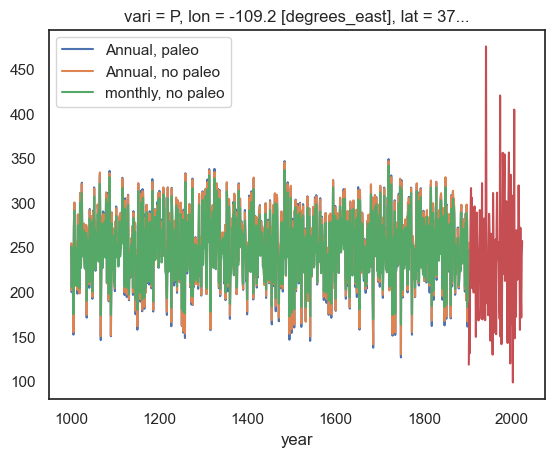

In [789]:
# test paleo
region="RMA"
vari="P"
hdi_prob=.66
paleo=APALEO[region]
nopaleo=ANNUALS[region]
monthly=MONTHLIES[region]
paleo.recover_original_units()
nopaleo.recover_original_units()
tax=paleo.taxes["recon"]
# az.plot_hdi(tax,paleo.pred["recon"].sel(vari=vari),smooth=False,hdi_prob=hdi_prob,color="r")
# az.plot_hdi(tax,nopaleo.pred["recon"].sel(vari=vari),smooth=False,hdi_prob=hdi_prob,color="k")
posterior_mean(paleo.pred["recon"].sel(vari=vari)).plot(label="Annual, paleo")
posterior_mean(nopaleo.pred["recon"].sel(vari=vari)).plot(label="Annual, no paleo")
if vari=="P":
    posterior_mean(monthly.pred["recon"].sel(vari=vari).sum(dim="month")).plot(label="monthly, no paleo")
else:
     posterior_mean(monthly.pred["recon"].sel(vari=vari).mean(dim="month")).plot(label="monthly, no paleo")
paleo.raw["M"].sel(vari=vari).plot()
plt.legend()

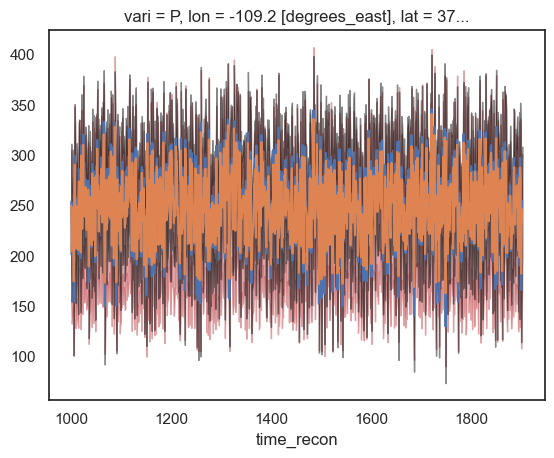

In [771]:
hdp_prob=.99

az.plot_hdi(tax,monthly.pred["recon"].sel(vari=vari).sum(dim="month"),smooth=False,hdi_prob=hdi_prob,color="r")
az.plot_hdi(tax,nopaleo.pred["recon"].sel(vari=vari),smooth=False,hdi_prob=hdi_prob,color="k")
posterior_mean(nopaleo.pred["recon"].sel(vari=vari)).plot(label="Annual, no paleo")
posterior_mean(monthly.pred["recon"].sel(vari=vari).sum(dim="month")).plot(label="monthly, no paleo")

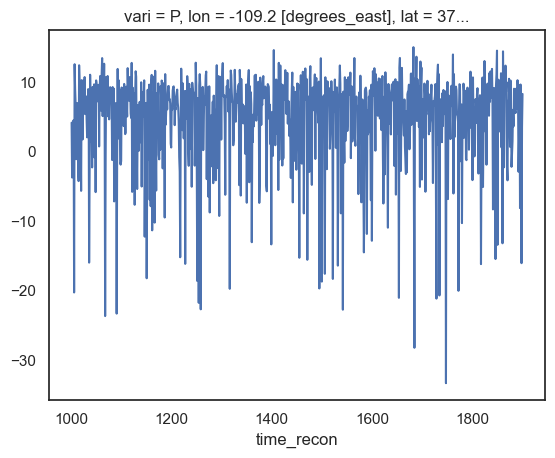

In [772]:
(posterior_mean(nopaleo.pred["recon"].sel(vari=vari))-posterior_mean(monthly.pred["recon"].sel(vari=vari).sum(dim="month"))).plot()

In [756]:
Xpaleo=get_annual_extrema(paleo,vari="P",kind="highest",roll=10)
Xnopaleo=get_annual_extrema(nopaleo,vari="P",kind="highest",roll=10)
Xmonth=get_extrema(region,vari="P",kind="highest",roll=10)

/var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/ipykernel_25345/1607038872.py:19: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  X=X.rolling(time=roll,center=False).mean(dim="time")


Most likely highest P [1334. 1333. 1065. 1314. 1840. 1491. 1326. 1727. 1493. 1066. 1618. 1118.
 1726. 1621. 1557. 1611. 1839. 1988. 1305. 1337. 1339. 1327. 1313. 1695.
 1841.]
10 lowest D  [1585. 1587. 1782. 1586. 1155. 1151. 1154. 1158. 1588. 1156. 1157. 1152.
 1153. 1285. 1781. 1592. 1584. 1159. 1286. 1099. 1737. 1591. 1590. 1282.
 1902.]
probability [4.85  3.45  2.75  2.225 2.1   1.875 1.825 1.775 1.725 1.525 1.45  1.425
 1.375 1.25  1.225 1.2   1.175 1.15  1.025 0.925 0.9   0.9   0.9   0.875
 0.85 ]


/var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/ipykernel_25345/1607038872.py:33: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['year']'. Passing the 'dim' kwarg to reduction operations has no effect.
  DTest=DTest.rolling(year=roll).mean(dim="year")
/var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/ipykernel_25345/1607038872.py:19: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  X=X.rolling(time=roll,center=False).mean(dim="time")


Most likely highest P [1334. 1840. 1333. 1988. 1065. 1314. 1491. 1066. 1841. 1326. 1118. 1727.
 1621. 1839. 1726. 1618. 1611. 1310. 1493. 1337. 1313. 1203. 1492. 1747.
 1305.]
10 lowest D  [1585. 1587. 1782. 1586. 1155. 1151. 1154. 1158. 1588. 1156. 1157. 1152.
 1153. 1285. 1781. 1592. 1584. 1159. 1286. 1099. 1737. 1591. 1590. 1282.
 1902.]
probability [4.35  2.6   2.45  2.375 2.35  2.15  2.    1.825 1.55  1.5   1.475 1.375
 1.375 1.275 1.275 1.225 1.225 1.075 1.025 0.975 0.95  0.925 0.9   0.875
 0.875]


/var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/ipykernel_25345/1607038872.py:33: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['year']'. Passing the 'dim' kwarg to reduction operations has no effect.
  DTest=DTest.rolling(year=roll).mean(dim="year")
/var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/ipykernel_25345/1872963366.py:20: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  X=X.rolling(time=roll,center=False).mean(dim="time")


Most likely highest P [1988. 1334. 1491. 1065. 1314. 1333. 1727. 1557. 1839. 1840. 1726. 1066.
 1611. 1088. 1310. 1337. 1306. 1492. 1203. 1313. 1119. 1621. 1321. 1339.
 1118.]
10 lowest D  [1585. 1587. 1782. 1586. 1155. 1151. 1154. 1158. 1588. 1156. 1157. 1152.
 1153. 1285. 1781. 1592. 1584. 1159. 1286. 1099. 1737. 1591. 1590. 1282.
 1902.]
probability [2.85  2.075 1.4   1.225 1.1   1.075 1.025 1.025 0.925 0.875 0.85  0.85
 0.775 0.75  0.725 0.725 0.675 0.65  0.65  0.625 0.625 0.625 0.6   0.6
 0.575]


/var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/ipykernel_25345/1872963366.py:34: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['year']'. Passing the 'dim' kwarg to reduction operations has no effect.
  DTest=DTest.rolling(year=roll).mean(dim="year")


<Axes: ylabel='Count'>

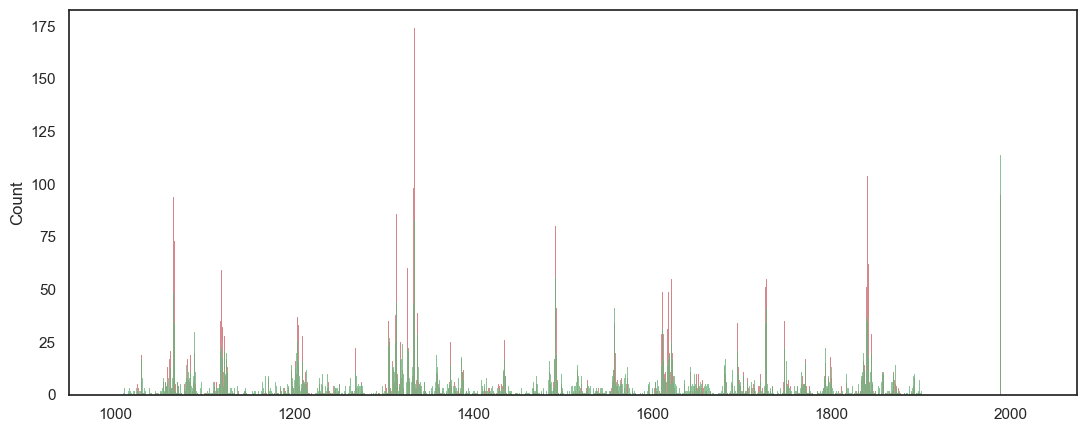

In [761]:
plt.figure(figsize=(13,5))
#sns.histplot(Xpaleo,bins=np.arange(1000,2024,1))
sns.histplot(Xnopaleo,bins=np.arange(1000,2024,1),color="r")
sns.histplot(Xmonth,bins=np.arange(1000,2024,1),color="g")

In [500]:
ANNUALS["PMS"]=ANNUALReconstructor("PMS")
ANNUALS["PMS"].make_model(validate_only=False,generate_trace=True,overwrite_trace=True,train_on_cru=True)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma, offset, noise_chol, beta, rhoD, sigmaD, sigma_proxy, Mval, D_cru_val, Grecon, Mrecon, D_cru_recon]


Output()

/Users/kmarvel/miniconda3/envs/reconstruction/lib/python3.13/site-packages/pytensor/compile/function/types.py:1039: RuntimeWarning: invalid value encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


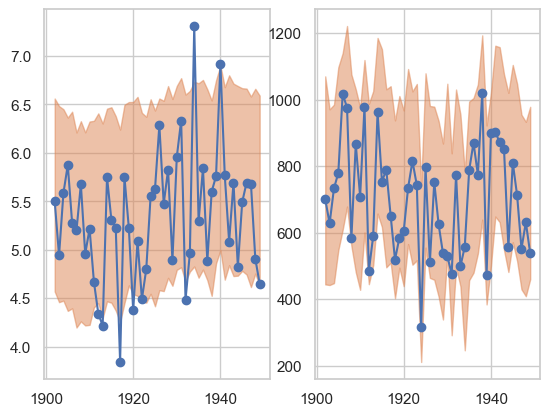

In [627]:
testpaleo.plot_validation()

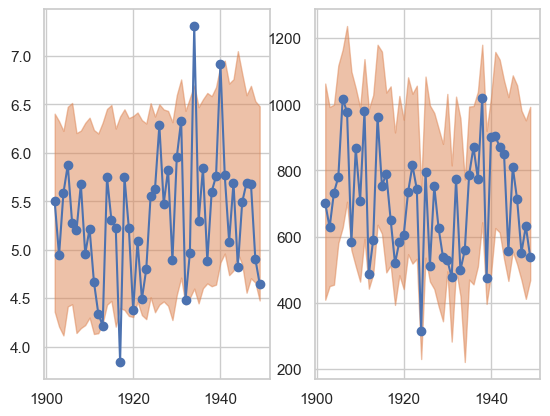

In [628]:
testnopaleo.plot_validation()

# Annual mean vs monthly
Monthly means have a small amount of additional uncertainty that comes from breaking down into months and the conversion to SPI and back

<Axes: >

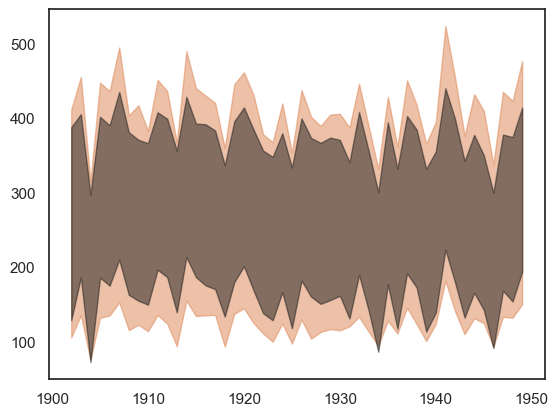

In [778]:
region="RMA"
vari="P"
x=MONTHLIES[region].taxes["val"]
monthly_results=MONTHLIES[region].pred["val"].sel(vari=vari)
az.plot_hdi(x,monthly_results.sum(dim="month"),smooth=False)
ANNUALS[region].recover_original_units()
annual_results=ANNUALS[region].pred["val"].sel(vari=vari)
az.plot_hdi(x,annual_results,smooth=False,color="k")


# Compare to Last Millennium Reanalysis

In [ ]:
lmrair=xr.open_dataset("../DATA/LMR/air_MCruns_ensemble_mean_LMRv2.1.nc",decode_times=False)
lmryears=lmrair.time.values/365
lmr_T=lmrair.air.rename({"time":"year"})
lmr_T["year"]=lmryears

lmrsp=xr.open_dataset("../DATA/LMR/air_MCruns_ensemble_spread_LMRv2.1.nc",\
                     decode_times=False)
lmrspyears=lmrsp.time.values/365
lmrsp=lmrsp.rename_vars({"air":"sp"})
lmr_sp=lmrsp.sp.rename({"time":"year"})
lmr_sp["year"]=lmryears

#lmr_T=lmrair.air.rename({"time":"year"}).mean(dim="MCrun")
#lmr_T["year"]=lmryears

LMR=xr.merge([lmr_T,lmr_sp])

In [236]:
lmrprate=xr.open_dataset("../DATA/LMR/prate_MCruns_ensemble_mean_LMRv2.1.nc",decode_times=False)
lmr_P=lmrprate.prate.rename({"time":"year"})
lmr_P["year"]=lmryears
lmrspp=xr.open_dataset("../DATA/LMR/prate_MCruns_ensemble_spread_LMRv2.1.nc",\
                     decode_times=False)

lmrspp=lmrspp.rename_vars({"prate":"sp"})
lmr_spp=lmrspp.sp.rename({"time":"year"})
lmr_spp["year"]=lmryears


LMRP=xr.merge([lmr_P,lmr_spp])

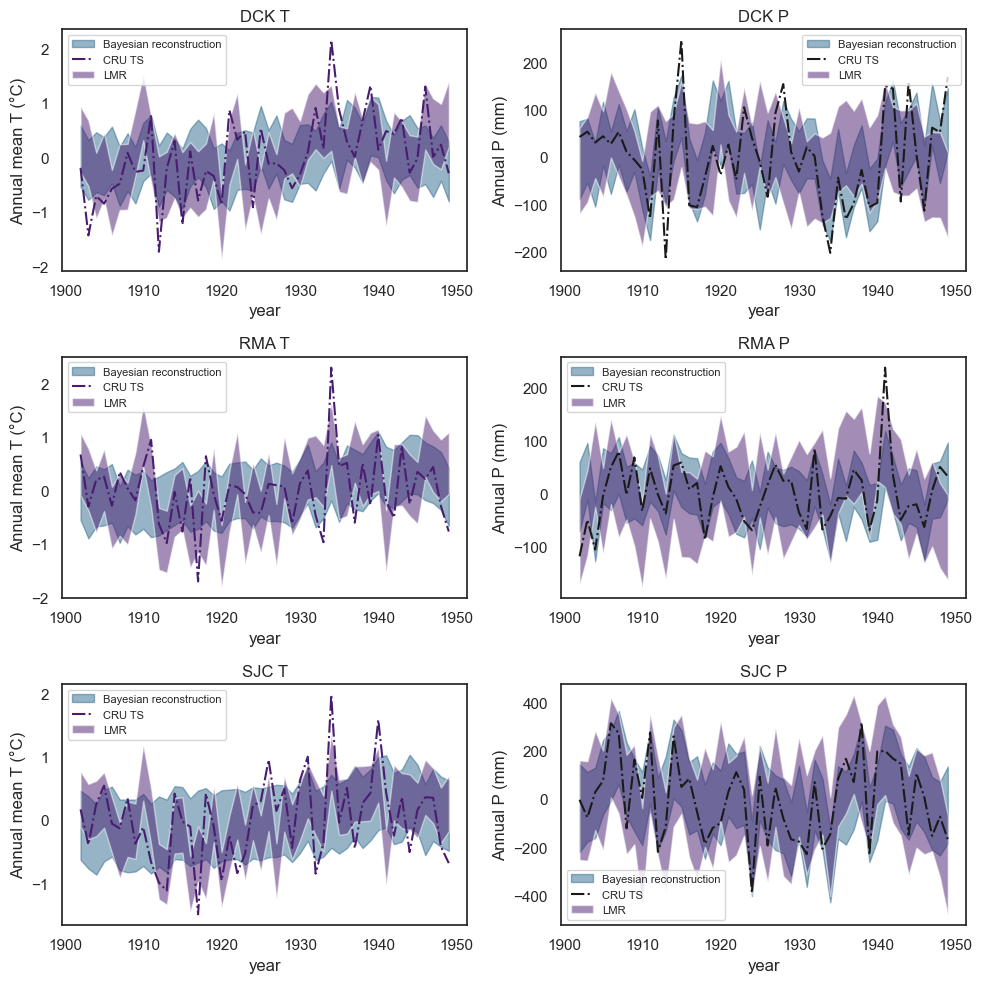

In [787]:
plotnum=1
plt.figure(figsize=(10,10))
with az.style.context("arviz-viridish"):
    for region in ["DCK","RMA","SJC"]:
        ANNUALS[region].recover_original_units()
        plt.subplot(3,2,plotnum)
        
        period="val"
        if period=="val":
            tdim="time_validate"
        else:
            tdim="time_recon"
        posterior=ANNUALS[region].pred[period].sel(vari="T")#.mean(dim="month")
        posterior_anom=posterior-posterior.mean(dim=tdim)
        az.plot_hdi(MONTHLIES[region].taxes[period],posterior_anom,smooth=False,hdi_prob=.66,\
                   fill_kwargs={"label": "Bayesian reconstruction"})
        
        
        if period != "recon":
            crudata=MONTHLIES[region].raw["M"].sel(year=MONTHLIES[region].taxes[period],vari="T").mean(dim="month")
            crudata_anom=crudata-crudata.mean(dim="year")
            crudata_anom.plot(ls="-.",label="CRU TS")
    
        lat,lon=latlon(region)
        lmrval=LMR.sel(lat=lat,lon=lon+360,method="nearest",year=MONTHLIES[region].taxes[period])
       
        #az.plot_hdi(MONTHLIES[region].taxes[period],myarray.stack(sample=["chain","draw"]).values.T,smooth=False,hdi_prob=.66)
    
        lmrmean=lmrval.mean(dim="MCrun").air
        lmrmean=(lmrmean-lmrmean.mean(dim="year")).values
        lmrstd=lmrval.mean(dim="MCrun").sp.values
        plt.fill_between(MONTHLIES[region].taxes[period],lmrmean-lmrstd,lmrmean+lmrstd,label="LMR",alpha=.5)
        #plt.plot(ANNUALS[region].taxes[period],lmrmean)
        plt.legend(fontsize=8)
        plt.title(region+" T")
        plt.ylabel("Annual mean T (°C)")
        plotnum+=1
        ##### PRECIP ####
        plt.subplot(3,2,plotnum)
        
       
        if period=="val":
            tdim="time_validate"
        else:
            tdim="time_recon"
        posterior=ANNUALS[region].pred[period].sel(vari="P")#.sum(dim="month")
        posterior_anom=(posterior-posterior.mean(dim=tdim))
        az.plot_hdi(ANNUALS[region].taxes[period],posterior_anom,smooth=False,hdi_prob=.66,\
                   fill_kwargs={"label": "Bayesian reconstruction"})
        
        
        if period == "val":
            crudata=MONTHLIES[region].raw["M"].sel(year=MONTHLIES[region].taxes[period],vari="P").sum(dim="month")
            crudata_anom=(crudata-crudata.mean(dim="year"))
            crudata_anom.plot(c="k",ls="-.",label="CRU TS")
    
        lat,lon=latlon(region)
        #if period == "val":
        lmrpval=LMRP.sel(lat=lat,lon=lon+360,method="nearest",year=MONTHLIES[region].taxes[period])*60*60*24*31*12
        # else:
        #     lmrval=LMRP.sel(lat=lat,lon=lon,method="nearest",year=slice(*MONTHLIES[region].reconstruction_period))*60*60*24*365
    
        
    
        lmrpmean=lmrpval.mean(dim="MCrun").prate
        lmrpmean=(lmrpmean-lmrpmean.mean(dim="year")).values
        lmrpstd=lmrpval.mean(dim="MCrun").sp.values
        plt.fill_between(MONTHLIES[region].taxes[period],lmrpmean-lmrpstd,lmrpmean+lmrpstd,label="LMR",alpha=.5)
        #plt.plot(ANNUALS[region].taxes[period],lmrpmean)
        plt.legend(fontsize=8)
        plt.title(region+" P")
        plt.ylabel("Annual P (mm)")
        plotnum+=1
    plt.tight_layout()
    plt.savefig("../RESULTS/FIGS/LMR_comparison_"+period+".pdf")
    #(crudata-crudata.mean(dim="year")).plot(c="r")

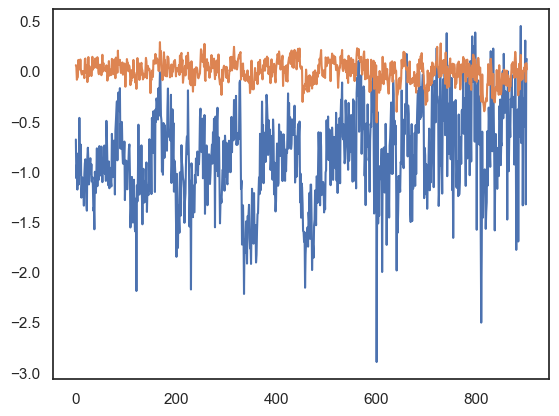

In [807]:
# Compare with LMR over the paleo period- how to visualize?
#APALEO["SJC"].reco
def get_lmr(region,vari,period):
    lat,lon=latlon(region)
    if vari == "T":
        lmrval=LMR.sel(lat=lat,lon=lon+360,method="nearest",year=MONTHLIES[region].taxes[period])
        lmrmean=lmrval.mean(dim="MCrun").air.values
        lmrstd=lmrval.mean(dim="MCrun").sp.values
       
    else:
        lmrval=LMRP.sel(lat=lat,lon=lon+360,method="nearest",year=MONTHLIES[region].taxes[period])
        lmrmean=lmrval.mean(dim="MCrun").prate.values*60*60*24*365
        lmrstd=lmrval.mean(dim="MCrun").sp.values*60*60*24*365
    return lmrmean,lmrstd
lmrmean,lmrstd=get_lmr("SJC","T","recon")
plt.plot(lmrmean)
APALEO["SJC"].recover_original_units()
pmean=posterior_mean(APALEO["SJC"].pred["recon"].sel(vari="T")).values
plt.plot(pmean-np.average(pmean))

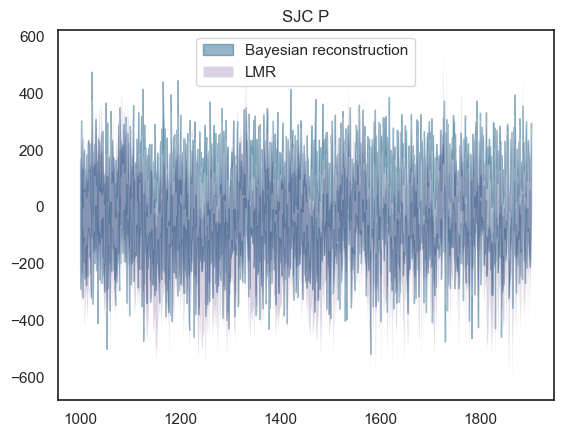

In [803]:
#az.plot_hdi(DCK.taxes["recon"],DCK.pred["recon"].sel(vari="T").mean(dim="month"),smooth=False)
with az.style.context("arviz-viridish"):
    vari="P"
    region="SJC"
    offset=ANNUALS[region].means["M"].sel(vari=vari)#float(ANNUALS[region].raw["M"].sel(year=slice(1951,1980),vari=vari).mean())
    
    #ANNUALS[region].recover_original_units()
    az.plot_hdi(ANNUALS[region].taxes["recon"],-offset+ANNUALS[region].pred["recon"].sel(vari=vari),smooth=False,hdi_prob=.66,\
               fill_kwargs={"label": "Bayesian reconstruction"})
    #posterior_mean(ANNUALS[region].pred["recon"].sel(vari=vari)).plot(c="r")
    #az.plot_hdi(DCK.taxes["val"],DCK.pred["val"].sel(vari="T").mean(dim="month"),smooth=False,color="c")
    #az.plot_hdi(ANNUALS[region].taxes["val"],ANNUALS[region].pred["val"].sel(vari=vari),smooth=False,color="r",hdi_prob=.66)
    #plt.xlim(1600,1950)
    # now plot the CRU data
    #ANNUALS[region].raw["M"].sel(vari=vari).plot(c="k",lw=.5)
    plt.title(region+" "+vari)

    lat,lon=latlon(region)
    lmrval=LMR.sel(lat=lat,lon=lon+360,method="nearest",year=MONTHLIES[region].taxes[period])
   
    #az.plot_hdi(MONTHLIES[region].taxes[period],myarray.stack(sample=["chain","draw"]).values.T,smooth=False,hdi_prob=.66)
    lat,lon=latlon(region)
    period="recon"
    if vari == "T":
        lmrval=LMR.sel(lat=lat,lon=lon+360,method="nearest",year=MONTHLIES[region].taxes[period])
        lmrmean=lmrval.mean(dim="MCrun").air.values
        lmrstd=lmrval.mean(dim="MCrun").sp.values
       
    else:
        lmrval=LMRP.sel(lat=lat,lon=lon+360,method="nearest",year=MONTHLIES[region].taxes[period])
        lmrmean=lmrval.mean(dim="MCrun").prate.values*60*60*24*365
        lmrstd=lmrval.mean(dim="MCrun").sp.values*60*60*24*365
        
    #az.plot_hdi(MONTHLIES[region].taxes[period],myarray.stack(sample=["chain","draw"]).values.T,smooth=False,hdi_prob=.66)
    
    
    lmrmean=lmrmean#+float(ANNUALS[region].raw["M"].sel(year=slice(1951,1980),vari=vari).mean())
    
    plt.fill_between(MONTHLIES[region].taxes[period],lmrmean-lmrstd,lmrmean+lmrstd,label="LMR",alpha=.2)
    #plt.plot(MONTHLIES[region].taxes[period],lmrmean)
    plt.legend()
    #plt.xlim(1300,1700)
    #plt.plot(MONTHLIES[region].taxes[period],lmrmean,c="k")

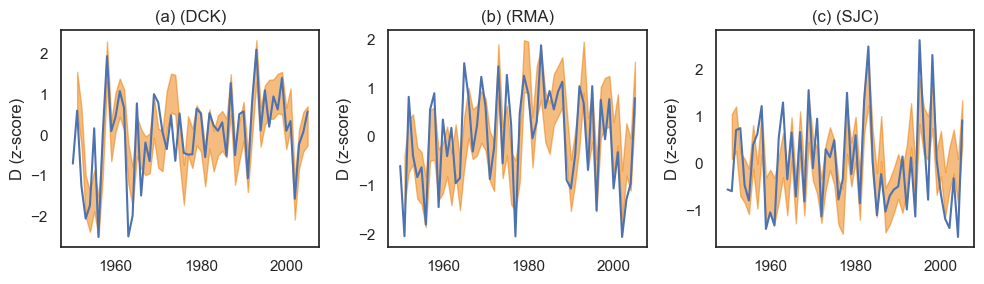

In [888]:
i=1
j=0
plt.figure(figsize=(10,3))
for region in ["DCK","RMA","SJC"]:
    plt.subplot(1,3,i)   
    with az.style.context("arviz-brownish"):
        ANNUALS[region].plot_posterior_predictive(hdi_prob=.66)
    plt.ylabel("D (z-score)")
    plt.title(letters[j]+" ("+region+")")
    i+=1
    j+=1
plt.tight_layout()
plt.savefig("../RESULTS/REVISION_FIGS/RevisedForwardModel.pdf")

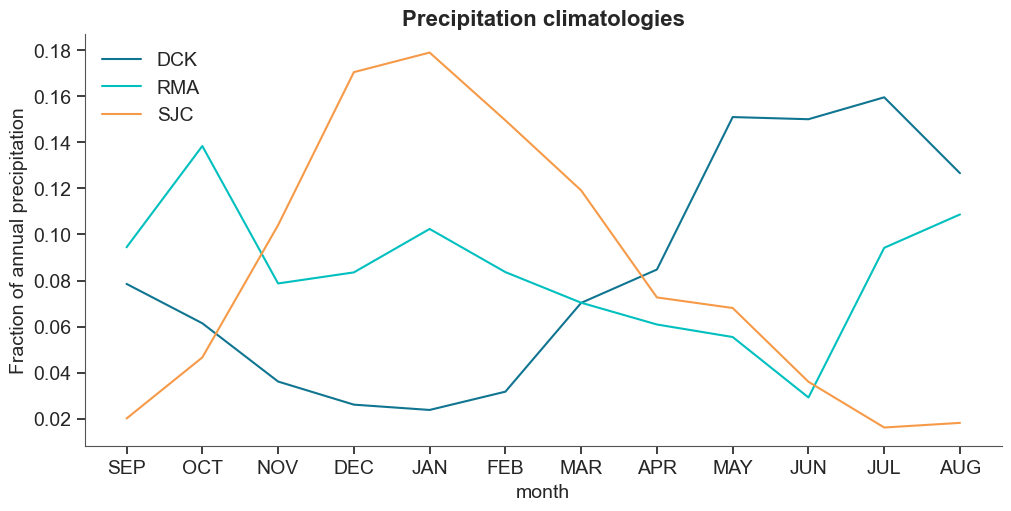

In [650]:
fig=plt.figure(figsize=(10,5))
savefigs=True
with az.style.context("arviz-doc"):
    for region in ["DCK","RMA","SJC"]:
        X=MONTHLIES[region]
        tst=X.means["M"].sel(vari="P")/X.means["M"].sel(vari="P").sum()
        tst.plot(label=X.region)
        
    
    #SJC.means["M"].sel(vari="P").plot(label="SJC")
    plt.legend()
    plt.title("Precipitation climatologies")
    plt.ylabel("Fraction of annual precipitation")
    if savefigs:
        plt.savefig("../RESULTS/FIGS/Pclim.pdf")
    plt.show()


In [651]:
DCK=MONTHLIES["DCK"]
RMA=MONTHLIES["RMA"]
SJC=MONTHLIES["SJC"]

In [407]:
def violinplot(trace,varname,ax=None):
   
    X=getattr(trace.posterior,varname)
    # X = xr.DataArray(np.random.randn(4, 1000, 12, 2), 
    #                  dims=["chain", "draw", "month", "vari"])
    
    # Convert to pandas DataFrame
    df = X.to_dataframe(name=varname).reset_index()

    sns.set_theme(style="whitegrid")
   
    my_pal={"T":"r","P":"b"}
    sns.violinplot(data=df, x='month', y=varname, hue='vari', split=True,inner="quart",gap=0.2,palette=my_pal,ax=ax)
    ax.axhline(0,c="k",ls=":")

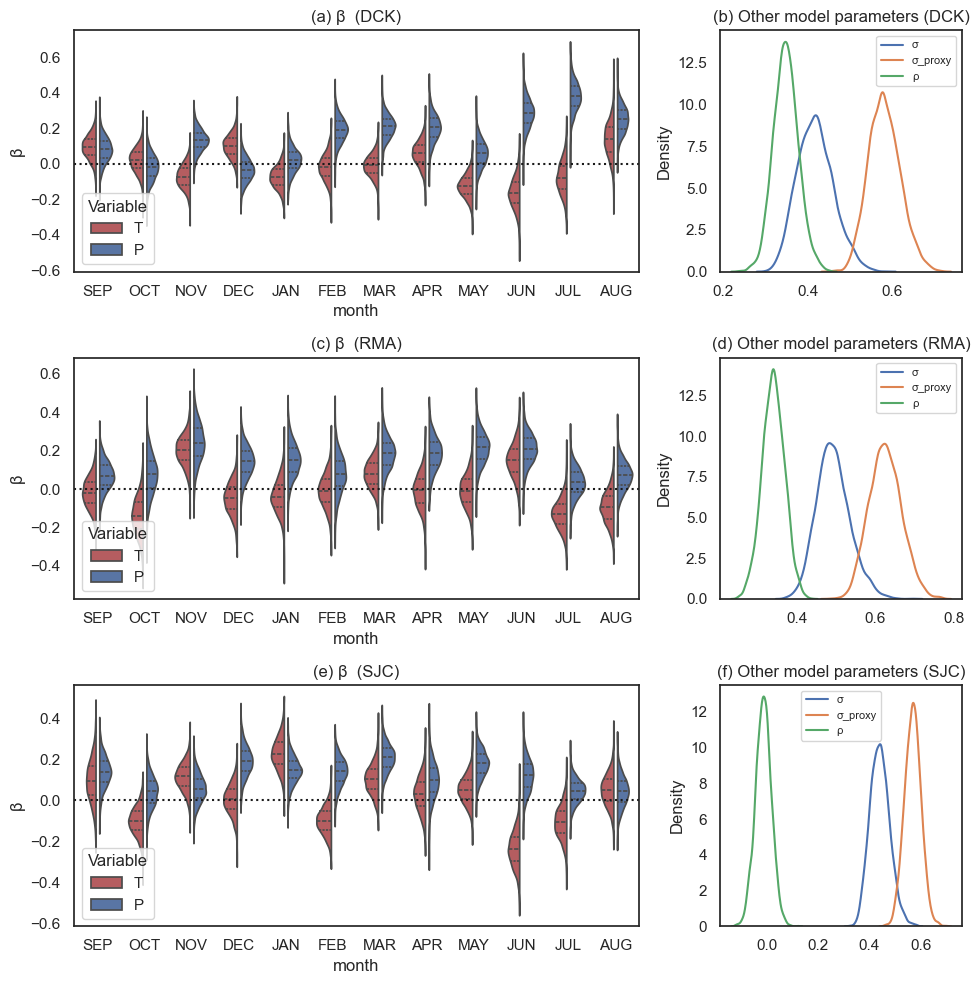

In [880]:
# Create a figure
fig = plt.figure(figsize=(10, 10))
from matplotlib.gridspec import GridSpec
# Create a GridSpec to control subplot layout
gs = GridSpec(3, 3, figure=fig)
letters = [f"({chr(c)})" for c in range(ord('a'), ord('f') + 1)]
sns.set_style("white")
i=0
j=0
for region in ["DCK","RMA","SJC"]:
    
    X=MONTHLIES[region]
   
    
   
    # Subplot 1 spans the top three panels (rows 0-1, columns 0-1)
    ax1 = fig.add_subplot(gs[i, :2])  # Spans the first  two columns
    violinplot(X.trace,"beta",ax=ax1)
    leg=plt.gca().legend()
    leg.set_title("Variable")
    leg.set_loc("lower left")
    leg.set_ncols(0)
    plt.ylabel("β")
    ax1.set_title(letters[j]+' β  ('+region+')')
    j+=1
    # Subplot 2 spans the bottom-left panel (row 0, column 2)
    sns.set_style("white")
    ax2 = fig.add_subplot(gs[i, 2])
    sns.kdeplot(X.trace.posterior.sigmaD.stack(samples=("chain","draw")),label="σ")
    sns.kdeplot(X.trace.posterior.sigma_proxy.stack(samples=("chain","draw")),label="σ_proxy")
    sns.kdeplot(X.trace.posterior.rhoD.stack(samples=("chain","draw")),label="ρ")
    ax2.legend(fontsize=8)
    ax2.set_title(letters[j]+' Other model parameters ('+region+')')
    i+=1
    j+=1
    # # Subplot 3 spans the bottom-right panel (row 1, column 1)
    # sns.set_style("white")
    # ax3 = fig.add_subplot(gs[1, 1])
    # ax3.set_title('Fit to training D')
    # with az.style.context("arviz-brownish"):
    #     X.plot_posterior_predictive(hdi_prob=.66)
    # plt.ylabel('D ('+region+')')
    
    # Adjust layout to prevent overlapping titles
plt.tight_layout()
plt.savefig("../RESULTS/REVISION_FIGS/ModelPosteriors.pdf")
    # if savefigs:
    #     plt.savefig("../RESULTS/FIGS/"+region+"_model_posteriors.pdf")

Sampling: [Dtrain_lik]


Output()

Sampling: [Dtrain_lik]


Output()

Sampling: [Dtrain_lik]


Output()

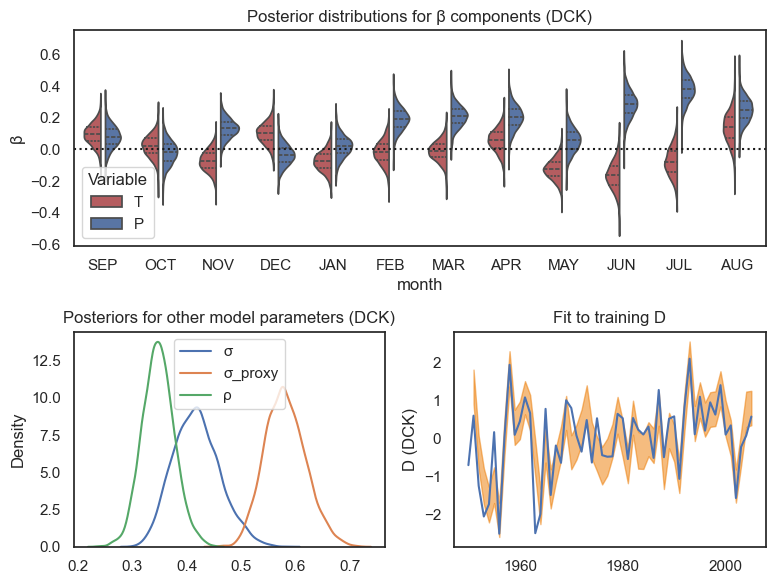

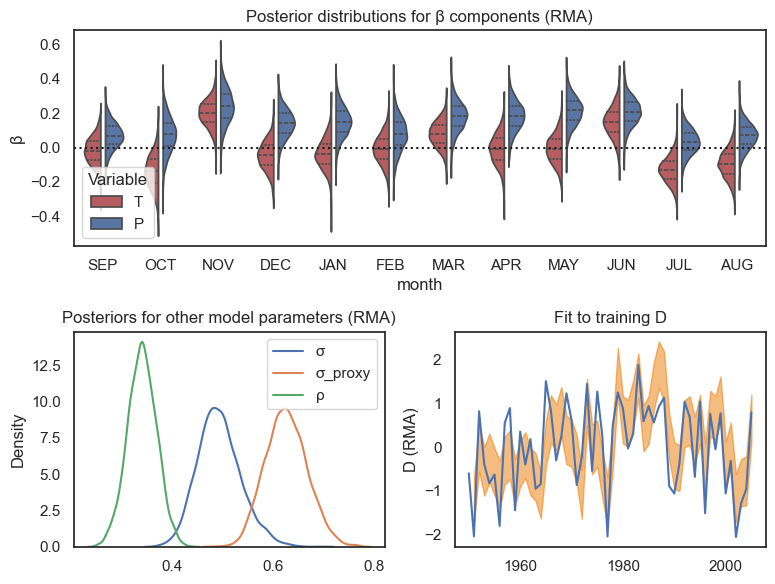

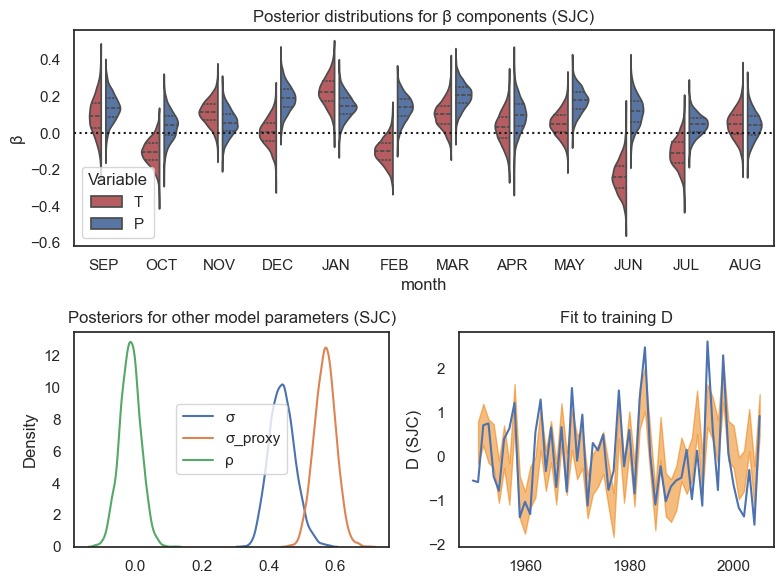

In [808]:
savefigs=True
    
sns.set_style("white")
    
for region in ["DCK","RMA","SJC"]:
    X=MONTHLIES[region]
    from matplotlib.gridspec import GridSpec
    
    # Create a figure
    fig = plt.figure(figsize=(8, 6))
    
    # Create a GridSpec to control subplot layout
    gs = GridSpec(2, 2, figure=fig)
    
    # Subplot 1 spans the top two panels (rows 0-1, columns 0-1)
    ax1 = fig.add_subplot(gs[0, :])  # Spans the first row
    violinplot(X.trace,"beta",ax=ax1)
    leg=plt.gca().legend()
    leg.set_title("Variable")
    leg.set_loc("lower left")
    leg.set_ncols(0)
    plt.ylabel("β")
    ax1.set_title('Posterior distributions for β components ('+region+')')
    
    # Subplot 2 spans the bottom-left panel (row 1, column 0)
    sns.set_style("white")
    ax2 = fig.add_subplot(gs[1, 0])
    sns.kdeplot(X.trace.posterior.sigmaD.stack(samples=("chain","draw")),label="σ")
    sns.kdeplot(X.trace.posterior.sigma_proxy.stack(samples=("chain","draw")),label="σ_proxy")
    sns.kdeplot(X.trace.posterior.rhoD.stack(samples=("chain","draw")),label="ρ")
    ax2.legend()
    ax2.set_title('Posteriors for other model parameters ('+region+')')
    
    # Subplot 3 spans the bottom-right panel (row 1, column 1)
    sns.set_style("white")
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.set_title('Fit to training D')
    with az.style.context("arviz-brownish"):
        X.plot_posterior_predictive(hdi_prob=.66)
    plt.ylabel('D ('+region+')')
    
    # Adjust layout to prevent overlapping titles
    plt.tight_layout()
    if savefigs:
        plt.savefig("../RESULTS/FIGS/"+region+"_model_posteriors.pdf")

/var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/ipykernel_25345/4039415890.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), size=8)


Text(0.5, 1.0, '(a): Posterior mean Σ')

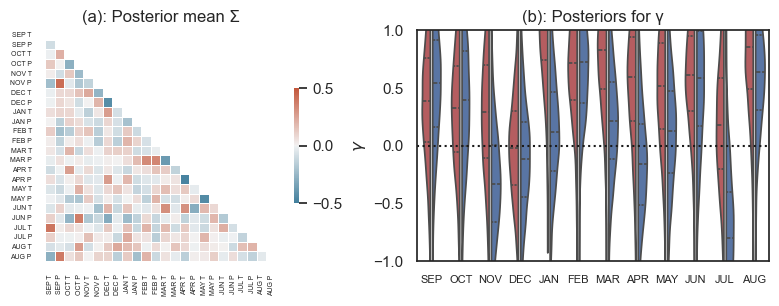

In [497]:
#az.style.use("arviz-default")
covmean=X.trace.posterior.cov.mean(dim=("chain","draw"))

Mcov=covmean
mask = np.triu(np.ones_like(Mcov, dtype=bool))
smooshed=[" ".join(x.split("_")) for x in covmean.smoosh.values]

# Set up the matplotlib figure
f=plt.figure(figsize=(10, 3))
ax=f.add_subplot(121)
#f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(Mcov, mask=mask, cmap=cmap, vmax=.5,vmin=-.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},ax=ax)
#plt.xticks(np.arange(len(smooshed))[::12],[x.split("_SEP")[0] for x in smooshed[::12]])
#plt.yticks(np.arange(len(smooshed))[::12],[x.split("_SEP")[0] for x in smooshed[::12]])
plt.xticks(np.arange(len(smooshed))+.5,smooshed,rotation=90,fontsize=5)
plt.yticks(np.arange(len(smooshed))+.5,smooshed,rotation=0, fontsize=5)
Mcov_masked=np.ma.masked_where(mask,Mcov.values)
ax2=f.add_subplot(122)

violinplot(X.trace,"gamma",ax=ax2)
ax2.set_ylabel(r"$\gamma$")

leg=ax2.get_legend()

leg.set_title("Variable")
ax2.set_xticklabels(ax2.get_xticklabels(), size=8)
#ax2.set_yticklabels(ax2.get_yticks(), size=5)
ax2.set_ylim(-1,1)

plt.setp(ax2.get_legend().get_texts(), fontsize='5')
plt.setp(ax2.get_legend().get_title(), fontsize='5') 
ax2.set_xlabel("")
leg.set_ncols(2)
leg.set_loc("lower left")
ax2.set_yticks([-1,-.5,0,.5,1])
leg.set_visible(False)
ax2.set_title("(b): Posteriors for γ")
ax.set_title("(a): Posterior mean Σ")
#ax2.set_xt
# leg.set_fontsize(5)
# i,j=np.unravel_index(np.argmin(Mcov_masked),Mcov.shape)
# print(smooshed[i],smooshed[j])
#plt.savefig("../RESULTS/FIGS/Covariance_DCK.pdf")

/var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/ipykernel_74477/1549204600.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


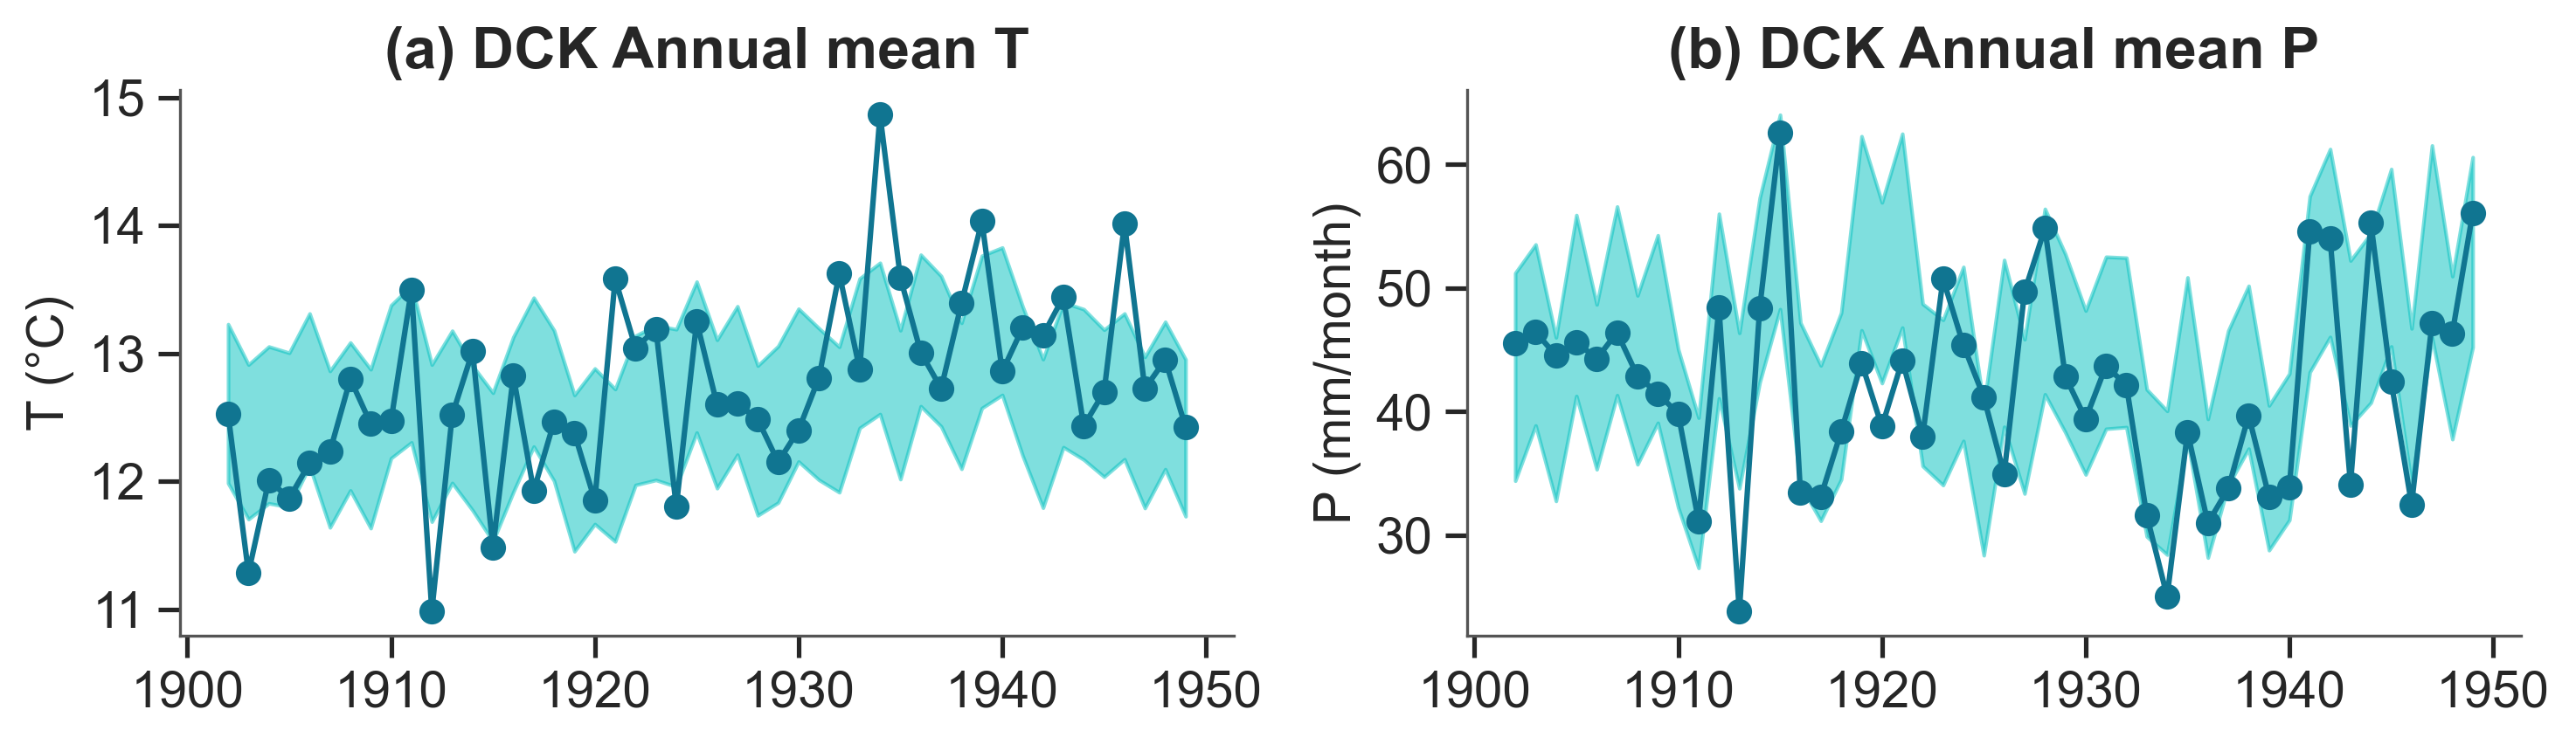

In [1115]:
fig=plt.figure(figsize=(10,3))
#DCK.plot_validation(months=["JUN","JUL","AUG"],hdi_prob=.66)
az.style.use("arviz-doc")
DCK.plot_validation(hdi_prob=.66)

fig.axes[0].set_title("(a) DCK Annual mean T")
fig.axes[0].set_ylabel("T (°C)")
fig.axes[1].set_title("(b) DCK Annual mean P")
fig.axes[1].set_ylabel("P (mm/month)")
plt.tight_layout()
#plt.savefig("../RESULTS/FIGS/DCK_annual_mean_validation.pdf")

/var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/ipykernel_74477/455249495.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


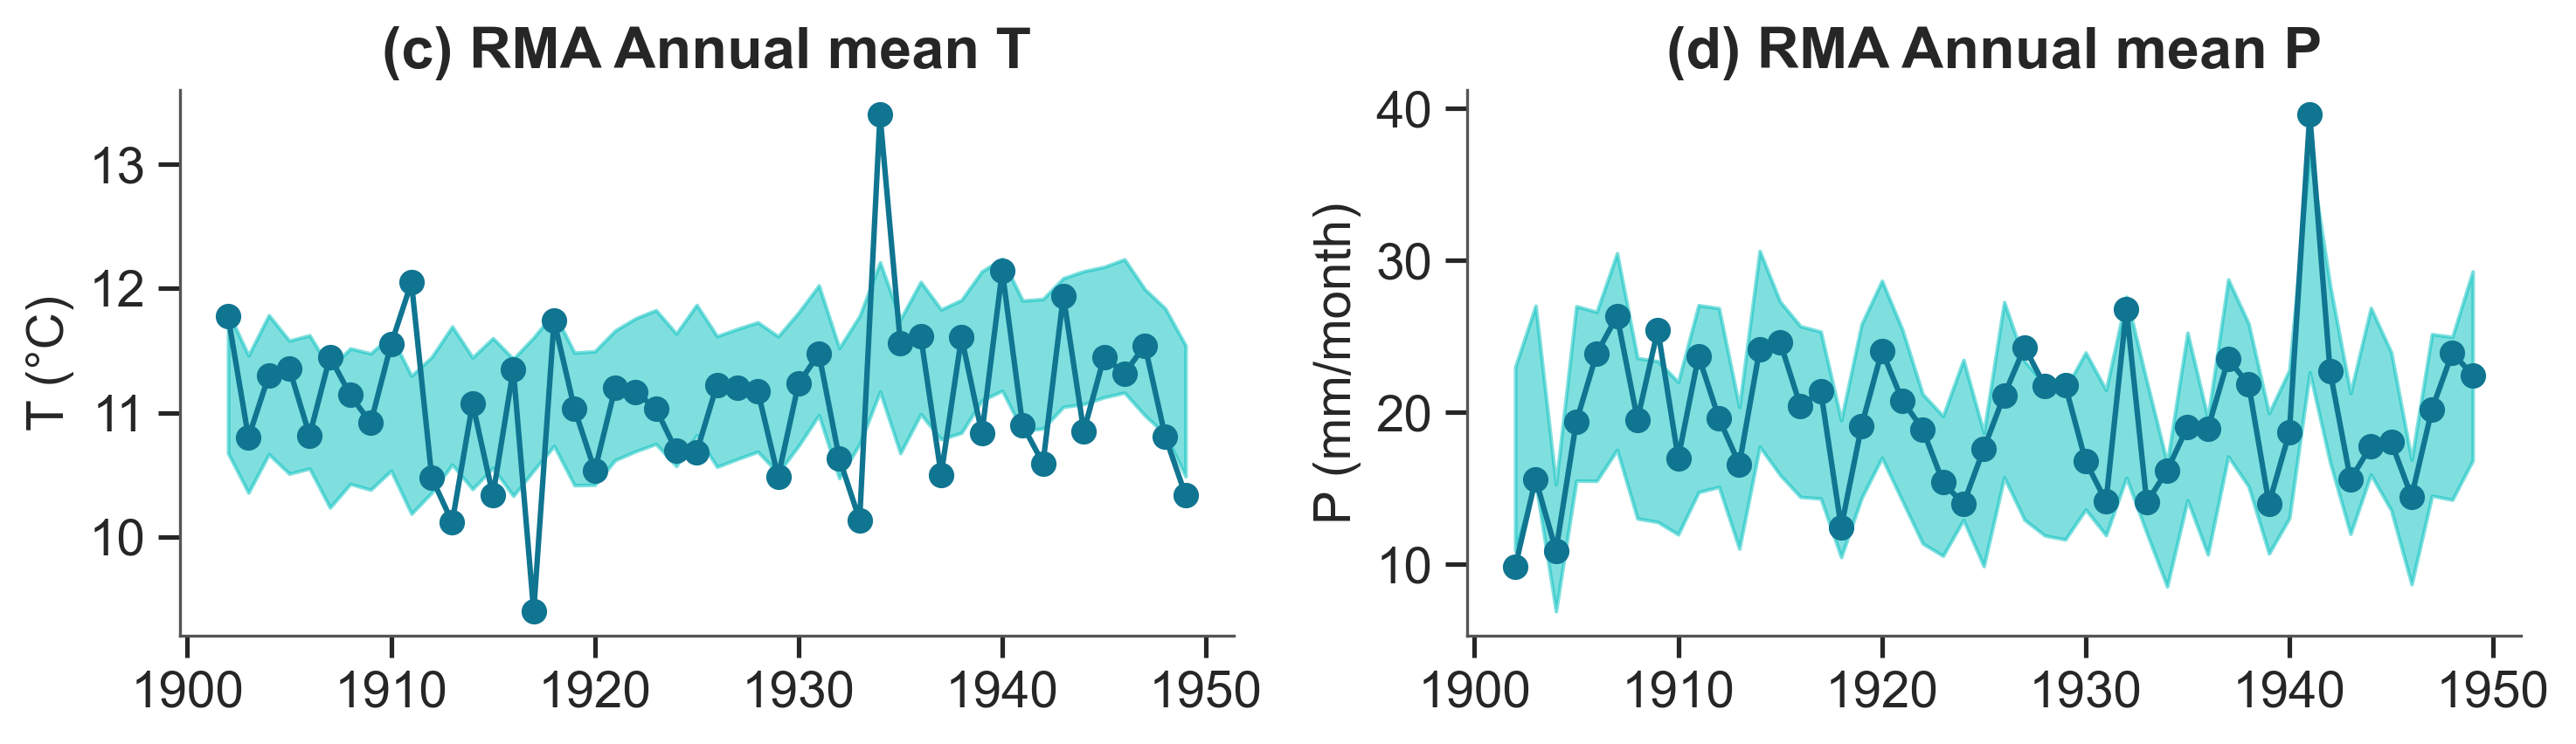

In [1118]:
fig=plt.figure(figsize=(10,3))
#DCK.plot_validation(months=["JUN","JUL","AUG"],hdi_prob=.66)
az.style.use("arviz-doc")
RMA.plot_validation(hdi_prob=.66)

fig.axes[0].set_title("(c) RMA Annual mean T")
fig.axes[0].set_ylabel("T (°C)")
fig.axes[1].set_title("(d) RMA Annual mean P")
fig.axes[1].set_ylabel("P (mm/month)")
plt.tight_layout()
#plt.savefig("../RESULTS/FIGS/RMA_annual_mean_validation.pdf")

/var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/ipykernel_74477/3148673485.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


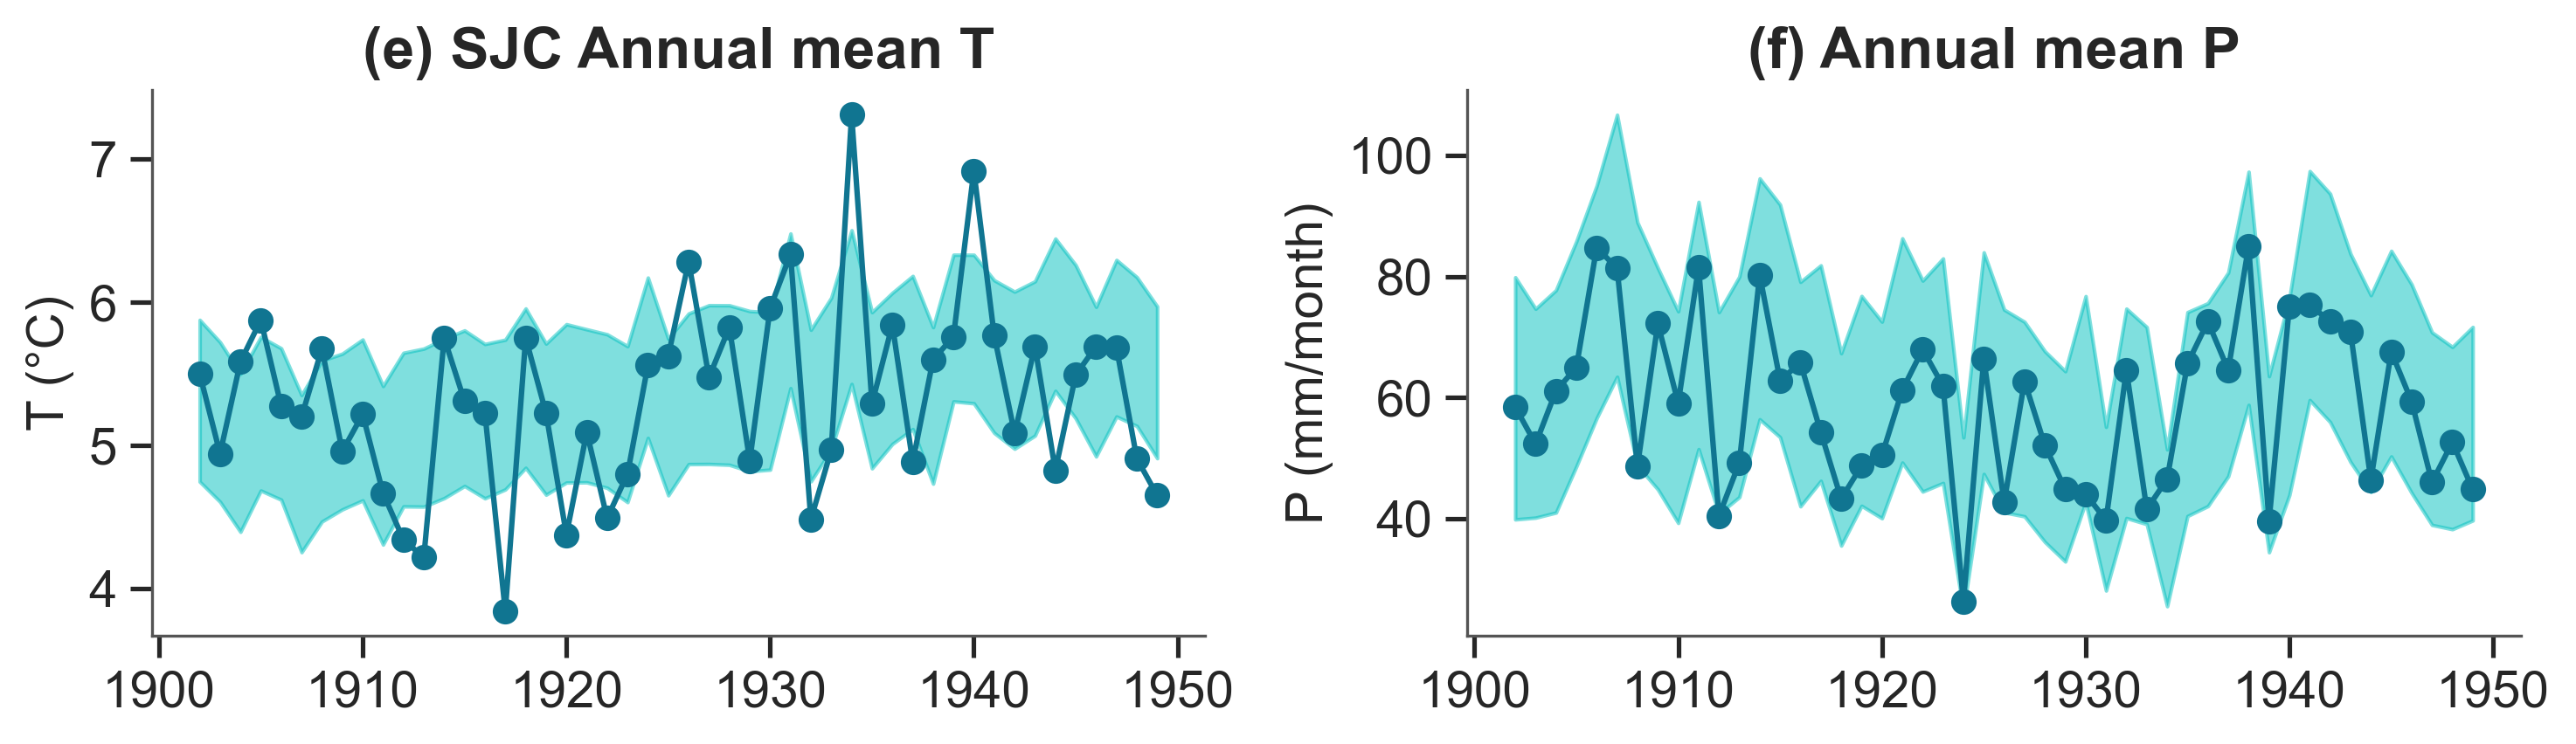

In [1117]:
fig=plt.figure(figsize=(10,3))
#DCK.plot_validation(months=["JUN","JUL","AUG"],hdi_prob=.66)
az.style.use("arviz-doc")
SJC.plot_validation(hdi_prob=.66)

fig.axes[0].set_title("(e) SJC Annual mean T")
fig.axes[0].set_ylabel("T (°C)")
fig.axes[1].set_title("(f) Annual mean P")
fig.axes[1].set_ylabel("P (mm/month)")
plt.tight_layout()
#plt.savefig("../RESULTS/FIGS/SJC_annual_mean_validation.pdf")

In [861]:
#1915: observations are a bit rainier than expected, and much colder


def plot_lowest(self,months=None,ylim=None,xlim=None,kind="kde"):
    year=self.taxes["val"][self.val["M"].sel(vari="P").mean(dim="month").argmin(dim="year")]
    
    #months=["DEC","JAN", "FEB"]
    if months is None:
        months=DCK.raw["M"].month.values
    Tmean,Pmean=self.raw["M"].sel(month=months,year=slice(*self.training_period)).mean(dim="month").mean(dim="year")
    with az.style.context("default"):
        axes=az.plot_pair(self.pred["val"].sel(time_validate=year,month=months).mean(dim="month"),kind=kind,marginals=True)
    obs=self.raw["M"].sel(year=year,month=months).mean(dim="month").values
    
    axes[1,0].plot([obs[0]],[obs[1]],marker="*",color="r",markersize=20,markeredgecolor="w")
    axes[1,0].set_xlabel("T (°C)")
    axes[1,0].set_ylabel("P (mm/month)")
    axes[1,0].axvline(float(Tmean),ls=":",c="k")
    axes[1,0].axhline(float(Pmean),ls=":",c="k")
    axes[1,1].axhline(float(obs[1]),color="r")
    if ylim is not None:
        axes[1,0].set_ylim(*ylim)
    if xlim is not None:
        axes[1,0].set_xlim(*xlim)
    
    axes[0,0].axvline(float(obs[0]),color="r")
    if self.region=="DCK":
        lab="(a) "
    elif self.region=="RMA":
        lab="(b) "
    elif self.region=="SJC":
        lab="(c) "
        
    plt.gcf().suptitle(lab+self.region+" "+str(year))

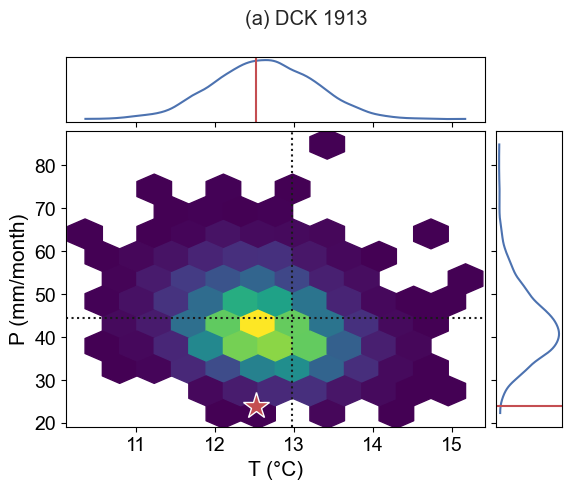

In [864]:
plot_lowest(MONTHLIES["DCK"],kind="hexbin")
#plt.savefig("LOWEST_DCK.pdf")

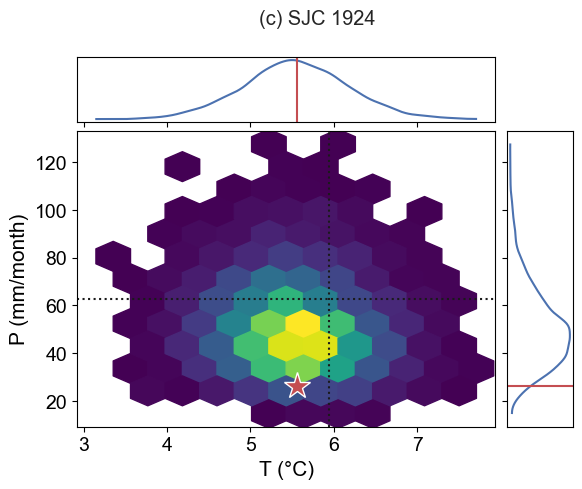

In [865]:
plot_lowest(SJC,kind="hexbin")
#plt.savefig("LOWEST_SJC.pdf")

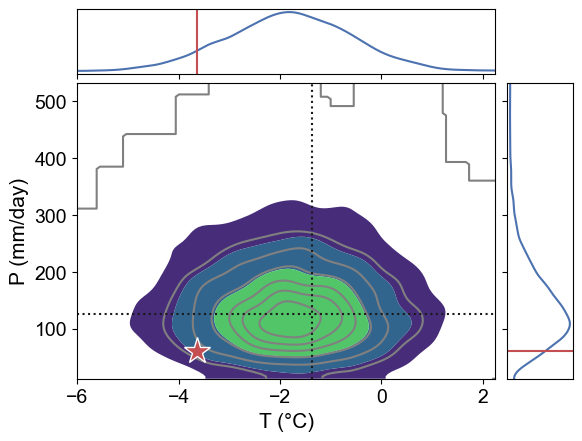

In [324]:
#1913 was a little colder than normal and MUCH drier.  
year=1913
self=SJC
months=["JUN","JUL", "AUG"]
#months=["MAR","APR","MAY"]
#months=["SEP","OCT","NOV"]
months=["DEC","JAN","FEB"]
#months=DCK.raw["M"].month.values
Tmean,Pmean=self.raw["M"].sel(month=months,year=slice(*DCK.training_period)).mean(dim="month").mean(dim="year")
with az.style.context("default"):
    axes=az.plot_pair(self.pred["val"].sel(time_validate=year,month=months).mean(dim="month"),kind="kde",marginals=True)
obs=self.raw["M"].sel(year=year,month=months).mean(dim="month").values

axes[1,0].plot([obs[0]],[obs[1]],marker="*",color="r",markersize=20,markeredgecolor="w")
axes[1,0].set_xlabel("T (°C)")
axes[1,0].set_ylabel("P (mm/day)")
axes[1,0].axvline(float(Tmean),ls=":",c="k")
axes[1,0].axhline(float(Pmean),ls=":",c="k")
axes[1,1].axhline(float(obs[1]),color="r")
#axes[1,0].set_ylim(20,60)

axes[0,0].axvline(float(obs[0]),color="r")
#plt.gcf().suptitle("Dodge City, Kansas: "+str(year))

/Users/kmarvel/miniconda3/envs/reconstruction/lib/python3.13/site-packages/arviz/data/base.py:272: UserWarning: More chains (1000) than draws (4). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


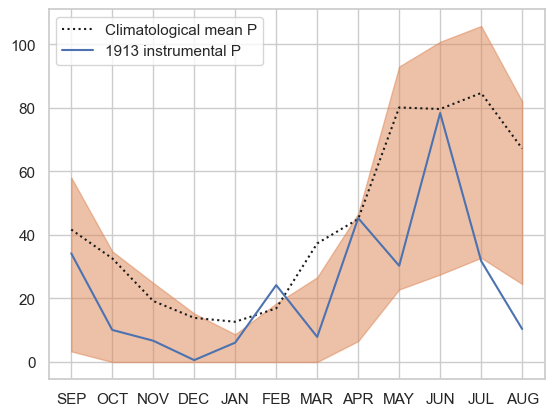

In [411]:
#check the seasonality
#az.style.use("arviz-doc")
fig=plt.figure()
ax=fig.add_subplot(111)
self=DCK
# year=1934
xax=np.arange(12)
# driest=self.pred["val"].sel(time_validate=year,vari="P")
# az.plot_hdi(xax,driest.T,smooth=False,ax=ax,color="forestgreen",hdi_prob=.66)

# ax.plot(xax,self.raw["M"].sel(year=year,vari="P").values,label='1934',color="forestgreen")
ax.plot(xax,self.means["M"].sel(vari="P").values,c="k",ls=":",label="Climatological mean P")

year=1913
xax=np.arange(12)
driest=self.pred["val"].sel(time_validate=year,vari="P")
az.plot_hdi(xax,driest.T,smooth=False,ax=ax,hdi_prob=.66)

ax.plot(xax,self.raw["M"].sel(year=year,vari="P").values,label='1913 instrumental P')
#ax.plot(xax,self.means["M"].sel(vari="P").values)
plt.legend()
tmp=plt.xticks(xax,self.raw["M"].month.values)
#plt.savefig("../RESULTS/FIGS/DCK1913.pdf")

# Comparing 1913 and 1934 in DCK
1913 had near-normal P in April and June and REALLY large deficits in March, May, and August.  Additionally, the fall and winter were exceptionally dry in 1913.  It probably shows up as normal in 

In [120]:
DCK.z["D"].sel(year=1913)

<xarray.DataArray 'pdsi' ()> Size: 8B
array(-0.19833403)
Coordinates:
    lon      float64 8B -100.2
    lat      float64 8B 37.75
    year     float64 8B 1.913e+03

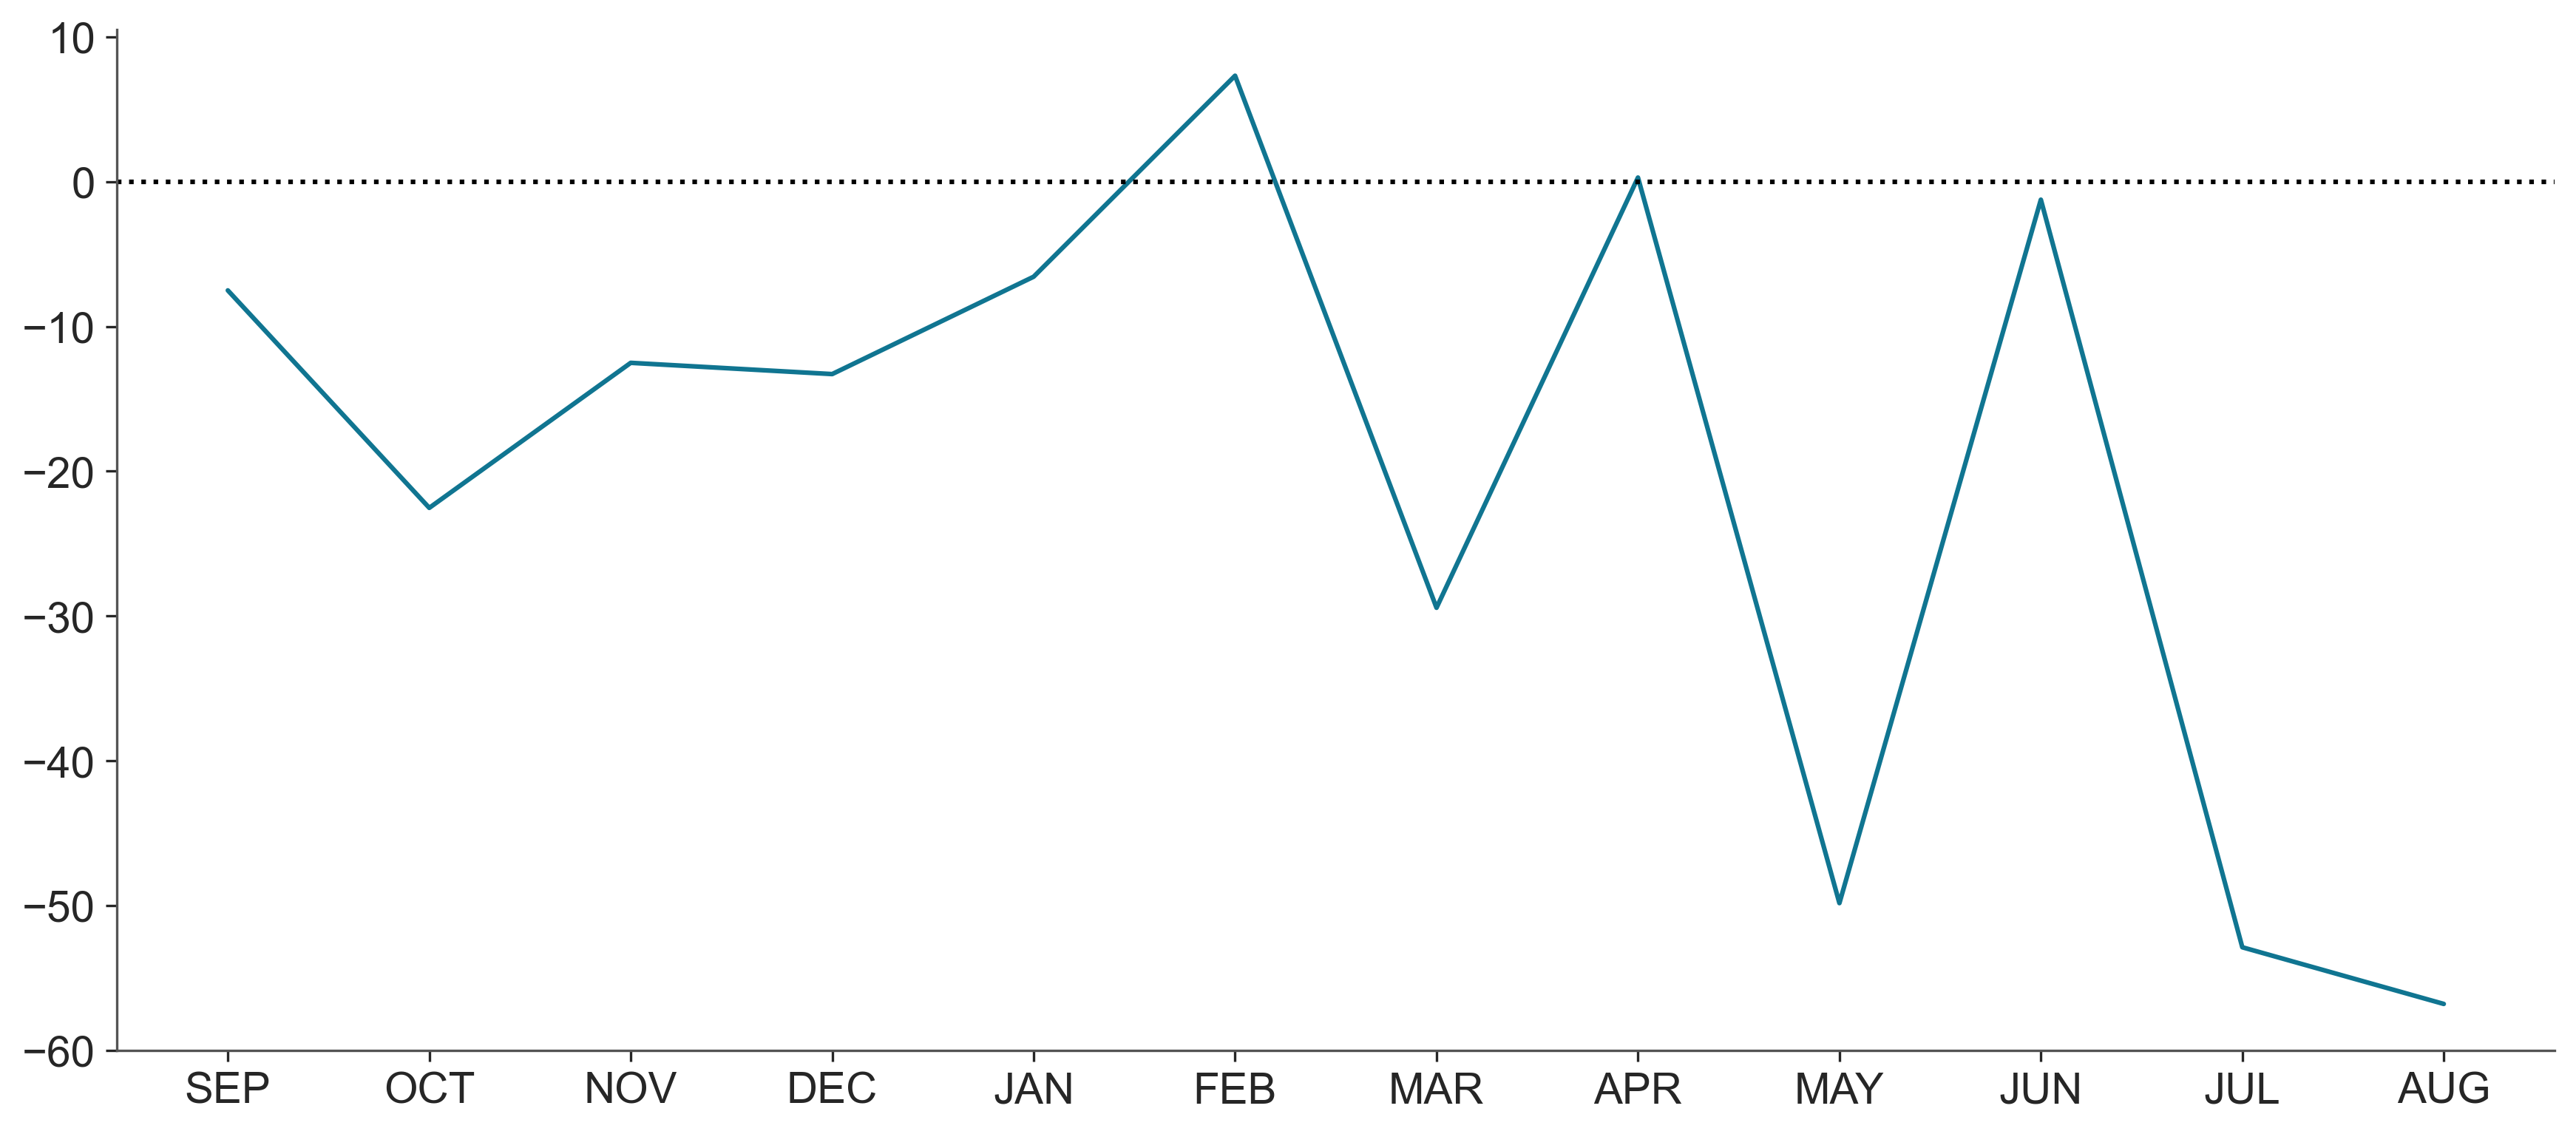

In [122]:
P1913=self.raw["M"].sel(year=1913,vari="P").values
P1934=self.raw["M"].sel(year=1934,vari="P").values
averageP=self.means["M"].sel(vari="P").values
plt.plot(P1913-averageP)
plt.axhline(0,c="k",ls=":")
np.sum(P1913-P1934)
tmp=plt.xticks(xax,self.raw["M"].month.values)

# 1934
The observations are a bit drier than predicted by the model, and much warmer
During the training period, most anomalously low values of PDSI were associated with precipitation deficits.  For example, the 1956 drought (D even lower than 1934) was associated with low summertime precipitation (roughly similar to 1934) but was 1.67 degrees colder.



/Users/kmarvel/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/pairplot.py:232: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  gridsize = int(dataset.dims["draw"] ** 0.35)


Text(0.5, 0.98, 'Dodge City, Kansas: 1934')

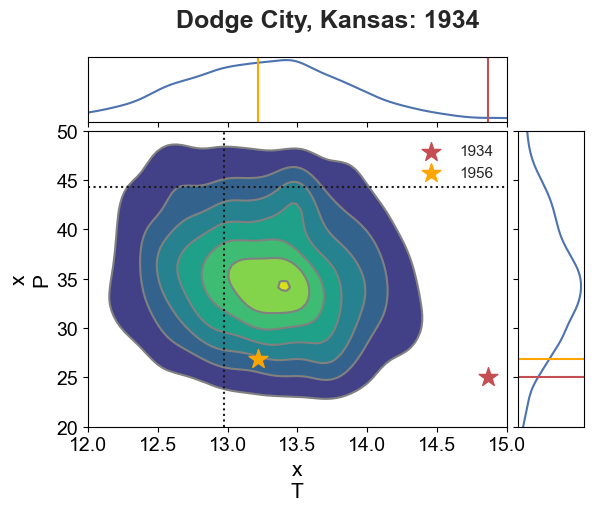

In [359]:
#1934: observations are a bit drier than expected, and much warmer
#During the training period, most anomalously low values of PDSI were associated with precipitation deficits.  For example, the 1956 drought was associated with low summertime precipitation (roughly similar to 1934) but was 1.67 degrees colder.
year=1934
compyear=1956
#months=["JUN","JUL", "AUG"]
months=DCK.raw["M"].month
with az.style.context("default"):
    axes=az.plot_pair(DCK.pred["val"].sel(time_validate=year,month=months).mean(dim="month"),kind="kde",marginals=True)
obs=DCK.raw["M"].sel(year=year,month=months).mean(dim="month").values
compare_with_training=DCK.raw["M"].sel(year=compyear,month=months).mean(dim="month").values
axes[1,0].scatter([obs[0]],[obs[1]],marker="*",color="r",s=200,label=str(year),zorder=2)
axes[1,0].scatter([compare_with_training[0]],[compare_with_training[1]],marker="*",color="orange",s=200,label=str(compyear),zorder=2)
axes[1,0].legend()

Tmean,Pmean=DCK.raw["M"].sel(month=months,year=slice(*DCK.training_period)).mean(dim="month").mean(dim="year")

axes[1,0].axvline(float(Tmean),ls=":",c="k")
axes[1,0].axhline(float(Pmean),ls=":",c="k")
axes[1,0].set_ylim(20,50)
axes[1,0].set_xlim(12,15)
axes[1,1].axhline(float(obs[1]),color="r")
axes[1,1].axhline(float(compare_with_training[1]),color="orange")

axes[0,0].axvline(float(obs[0]),color="r")
axes[0,0].axvline(float(compare_with_training[0]),color="orange")
plt.gcf().suptitle("Dodge City, Kansas: 1934")


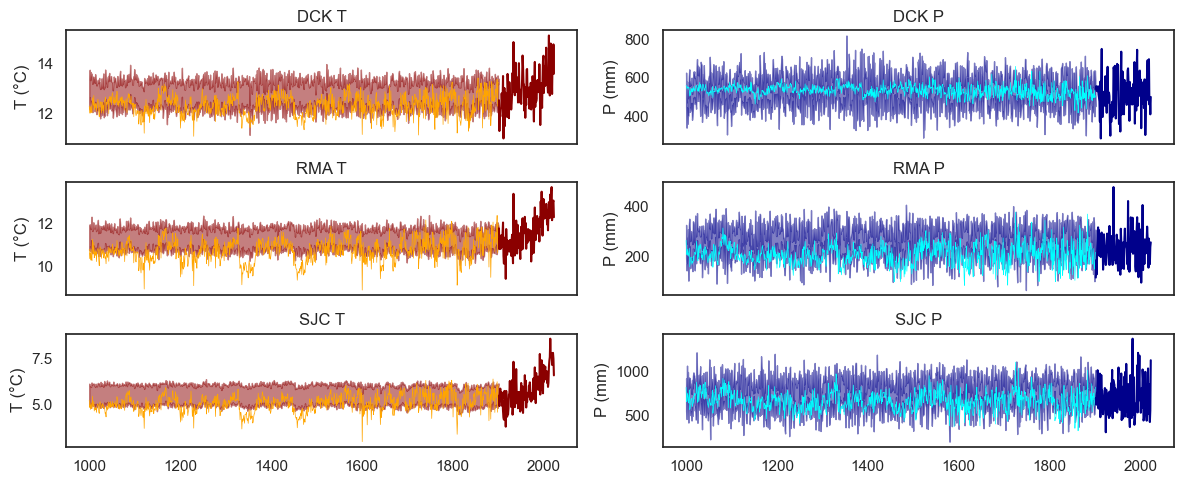

In [851]:
fig=plt.figure(figsize=(12,5))
sns.set_style("white")
axes=[]
i=1
use_paleo_G=True

hdi_prob=.66
for region in ["DCK","RMA","SJC"]:
    if use_paleo_G:
        X=APALEO[region]
        
    else:
        X=ANNUALS[region]
    if not hasattr(X,"pred"):
        X.recover_original_units()
    ax=fig.add_subplot(3,2,i)
    axes+=[ax]
    #roll10=X.pred["recon"].mean(dim="month").sel(vari="T")
    roll10=X.pred["recon"].sel(vari="T")
    # if use_paleo_G:
    #     offset=roll10.mean(dim="time_recon")
    #     roll10=roll10-offset
    az.plot_hdi(roll10.time_recon.values,roll10,smooth=False,hdi_prob=hdi_prob,color="darkred",ax=ax)
    if use_paleo_G:
        lmrmean,lmrstd=get_lmr(region,"T","recon")
        #plt.plot(roll10.time_recon.values,lmrmean-lmrmean.mean(),lw=.5,color="orange")
        #plt.plot(roll10.time_recon.values,lmrmean+float(X.raw["M"].sel(year=slice(1951,1980),vari="T").mean()))
        plt.plot(roll10.time_recon.values,lmrmean+float(X.means["M"].sel(vari="T")),lw=.5,color="orange")
    
   # az.plot_hdi(roll10.time_validate.values,roll10,smooth=False,hdi_prob=hdi_prob,color="orange")
    
    #roll10raw=X.raw["M"].mean(dim="month").sel(vari="T")
    roll10raw=X.raw["M"].sel(vari="T")
    # if use_paleo_G:
    #     roll10raw=roll10raw-float(posterior_mean(offset))
       
    ax.plot(roll10raw.year.values,roll10raw.values,color='darkred')
    ax.set_title(X.region+" T")
    ax.set_ylabel("T (°C)")
    if i != 5:
        ax.set_xticks([])
    i=i+1
    ax=fig.add_subplot(3,2,i)
    axes+=[ax]
    #roll10=X.pred["recon"].mean(dim="month").sel(vari="P")
    roll10=X.pred["recon"].sel(vari="P")
    # if use_paleo_G:
    #     offset=roll10.mean(dim="time_recon")
    #     roll10=roll10-offset
    az.plot_hdi(roll10.time_recon.values,roll10,smooth=False,hdi_prob=hdi_prob,color="darkblue",ax=ax)
    if use_paleo_G:
        lmrmean,lmrstd=get_lmr(region,"P","recon")
        #plt.plot(roll10.time_recon.values,lmrmean-lmrmean.mean(),lw=.5,color="cyan")
        #plt.plot(roll10.time_recon.values,lmrmean+float(X.raw["M"].sel(year=slice(1951,1980),vari="T").mean()))
        plt.plot(roll10.time_recon.values,lmrmean+float(X.means["M"].sel(vari="P")),lw=.5,color="cyan")
    
    #roll10raw=X.raw["M"].mean(dim="month").sel(vari="P")
    roll10raw=X.raw["M"].sel(vari="P")
    # if use_paleo_G:
    #     roll10raw=roll10raw-float(posterior_mean(offset))
        
    
   # az.plot_hdi(roll10.time_validate.values,roll10,smooth=False,hdi_prob=hdi_prob,color="orange")
    
    ax.set_title(X.region+" P")
    ax.plot(roll10raw.year.values,roll10raw.values,color='darkblue')
    ax.set_ylabel("P (mm)")
    if i != 6:
        ax.set_xticks([])
   
    i=i+1
plt.tight_layout()


#plt.show()
if use_paleo_G:
    plt.savefig("../RESULTS/FIGS/Reconstructions_WITH_PALEO.pdf")
else:
    plt.savefig("../RESULTS/FIGS/Reconstructions.pdf")

In [ ]:
# Checking if gamma function is a good fit

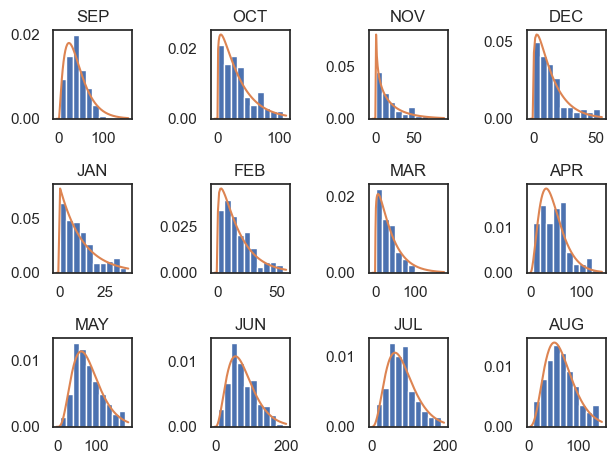

In [664]:
npanel=1
region="DCK"
for month in MONTHLIES[region].raw["M"].month.values:
    plt.subplot(3,4,npanel)
    MONTHLIES[region].raw["M"].sel(vari="P",month=month).plot.hist(density=True)
    x0,x1=plt.xlim()
    x=np.arange(x0,x1,1)
    pdf=stats.gamma.pdf(x,*MONTHLIES[region].gamma_params[month])
    plt.plot(x,pdf)
    plt.title(month)
    npanel+=1
plt.tight_layout()
#plt.savefig("../RESULTS/FIGS/gammacheck.pdf")   

In [693]:
#Pluvial year: 
region="DCK"
vari="P"
kind="lowest"
roll=None

def get_annual_extrema(self,vari,kind="lowest",roll=None,verbose=True):
    #self=ANNUALS[region]
    
    recon_M=self.pred["recon"].rename({"time_recon":"time"}).stack(sample=("chain","draw")).transpose("vari","time","sample")
    #print(recon_M.shape)
    rawdata=np.repeat(self.raw["M"].values[:,:,np.newaxis],4000,axis=-1)
    coords={"vari":recon_M.vari.values,\
    "time":self.raw["M"].year.values,\
    "sample":recon_M.sample}
    recent_M=xr.DataArray(data=rawdata,coords=coords)
    X=xr.concat([recon_M,recent_M],dim="time")
    if roll is not None:
        X=X.rolling(time=roll,center=False).mean(dim="time")
    #X=DCK.pred["recon"].mean(dim="month").rename({"time_recon":"time"}).stack(sample=("chain","draw"))
    if kind == "lowest":
        extreme=X.time[X.argmin(dim=("time"))]
    else:
        extreme=X.time[X.argmax(dim=("time"))]
    L=len(X.time)
    
    extreme=extreme.sel(vari=vari)
    counts,bins=np.histogram(extreme,bins=X.time.values,density=True)
    if verbose:
        print("Most likely "+kind+" "+vari ,X.time.values[np.argsort(counts)][::-1][:25])
    DTest=self.raw["D"].sel(year=slice(1000,2005))
    if roll is not None:
        DTest=DTest.rolling(year=roll).mean(dim="year")
    if verbose:
        print("10 lowest D ",DTest.year.values[np.argsort(DTest)][:25])
        #print("probability",100*(np.sort(counts)[::-1][:25]/4000))
        print("probability",100*(np.sort(counts)[::-1][:25]))
    #plt.xlim(1000,2023)
    return extreme

In [702]:
testpaleo.recover_original_units()
testnopaleo.recover_original_units()
kind="lowest"
paleo_ex=get_annual_extrema(testpaleo,kind=kind,vari="P",roll=10)
nopaleo_ex=get_annual_extrema(testnopaleo,kind=kind,vari="P",roll=10)

/var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/ipykernel_25345/1607038872.py:19: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  X=X.rolling(time=roll,center=False).mean(dim="time")


Most likely lowest P [1905. 1959. 1585. 1151. 1782. 1904. 1158. 1154. 1099. 1587. 1285. 1737.
 1781. 1592. 1044. 1632. 1757. 1010. 1009. 1457. 1827. 1670. 1480. 1908.
 1155.]
10 lowest D  [1585. 1587. 1782. 1586. 1155. 1151. 1154. 1158. 1588. 1156. 1157. 1152.
 1153. 1285. 1781. 1592. 1584. 1159. 1286. 1099. 1737. 1591. 1590. 1282.
 1902.]
probability [10.65   5.075  2.825  2.45   2.35   2.3    1.825  1.45   1.45   1.45
  1.35   1.325  1.275  1.1    1.075  1.025  1.025  0.975  0.825  0.8
  0.775  0.75   0.75   0.75   0.75 ]


/var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/ipykernel_25345/1607038872.py:33: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['year']'. Passing the 'dim' kwarg to reduction operations has no effect.
  DTest=DTest.rolling(year=roll).mean(dim="year")
/var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/ipykernel_25345/1607038872.py:19: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  X=X.rolling(time=roll,center=False).mean(dim="time")


Most likely lowest P [1905. 1959. 1585. 1151. 1782. 1904. 1285. 1099. 1737. 1781. 1158. 1044.
 1154. 1587. 1014. 1140. 1757. 1632. 1155. 1010. 1592. 1902. 1671. 1588.
 1254.]
10 lowest D  [1585. 1587. 1782. 1586. 1155. 1151. 1154. 1158. 1588. 1156. 1157. 1152.
 1153. 1285. 1781. 1592. 1584. 1159. 1286. 1099. 1737. 1591. 1590. 1282.
 1902.]
probability [10.625  6.95   2.7    2.575  2.35   2.15   1.8    1.625  1.45   1.375
  1.35   1.3    1.175  1.125  1.1    1.075  1.05   1.     0.95   0.925
  0.925  0.925  0.925  0.825  0.7  ]


/var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/ipykernel_25345/1607038872.py:33: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['year']'. Passing the 'dim' kwarg to reduction operations has no effect.
  DTest=DTest.rolling(year=roll).mean(dim="year")


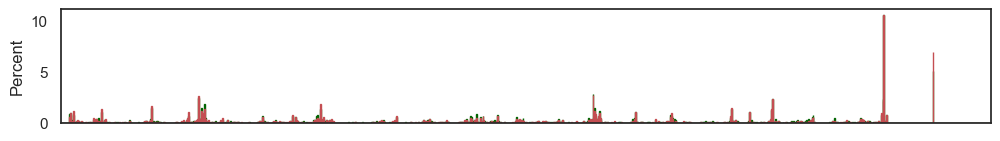

In [703]:
fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(311)
sns.histplot(paleo_ex,bins=np.arange(1000,2024),edgecolor=color,stat='percent',ax=ax,linewidth=1)
sns.histplot(nopaleo_ex,bins=np.arange(1000,2024),edgecolor="r",stat='percent',ax=ax,linewidth=1)
ax.set_xlim(1000,2023)
ax.set_xticks([])

plt.show()

In [707]:
#Pluvial year: 
self=DCK
vari="P"
kind="lowest"
roll=None

def get_extrema(region,vari,kind="lowest",roll=None,verbose=True):
    self=MONTHLIES[region]
    recon_M=self.pred["recon"].rename({"time_recon":"time"}).stack(sample=("chain","draw")).transpose("month","vari","time","sample")
    #print(recon_M.shape)
    rawdata=np.repeat(self.raw["M"].values[:,:,:,np.newaxis],4000,axis=-1)
    coords={"month":recon_M.month.values,\
    "vari":recon_M.vari.values,\
    "time":self.raw["M"].year.values,\
    "sample":recon_M.sample}
    recent_M=xr.DataArray(data=rawdata,coords=coords)
   # X=xr.concat([recon_M,recent_M],dim="time").mean(dim="month")
    X=xr.concat([recon_M,recent_M],dim="time").sum(dim="month")
    if roll is not None:
        X=X.rolling(time=roll,center=False).mean(dim="time")
    #X=DCK.pred["recon"].mean(dim="month").rename({"time_recon":"time"}).stack(sample=("chain","draw"))
    if kind == "lowest":
        extreme=X.time[X.argmin(dim=("time"))]
    else:
        extreme=X.time[X.argmax(dim=("time"))]
    L=len(X.time)
    
    extreme=extreme.sel(vari=vari)
    counts,bins=np.histogram(extreme,bins=X.time.values,density=True)
    if verbose:
        print("Most likely "+kind+" "+vari ,X.time.values[np.argsort(counts)][::-1][:25])
    DTest=self.raw["D"].sel(year=slice(1000,2005))
    if roll is not None:
        DTest=DTest.rolling(year=roll).mean(dim="year")
    if verbose:
        print("10 lowest D ",DTest.year.values[np.argsort(DTest)][:25])
        #print("probability",100*(np.sort(counts)[::-1][:25]/4000))
        print("probability",100*(np.sort(counts)[::-1][:25]))
    #plt.xlim(1000,2023)
    return extreme

******* DCK *******


/var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/ipykernel_25345/3117181462.py:18: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  X=X.rolling(time=roll,center=False).mean(dim="time")


Most likely highest P [2001. 1519. 1359. 1120. 1362. 1521. 1664. 1314. 1434. 1360. 1665. 1662.
 1121. 1435. 1661. 1125. 1214. 1032. 1326. 1844. 1520. 1845. 1034. 1334.
 1122.]
10 lowest D  [1864. 1865. 1424. 1941. 1940. 1108. 1106. 1107. 1863. 1010. 1868. 1866.
 1425. 1942. 1105. 1151. 1011. 1856. 1869. 1509. 1423. 1824. 1867. 1009.
 1587.]
probability [35.025  3.875  3.025  2.95   2.425  2.35   2.025  1.9    1.525  1.45
  1.425  1.125  1.1    1.075  1.     0.875  0.825  0.825  0.775  0.75
  0.725  0.7    0.675  0.65   0.625]


/var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/ipykernel_25345/3117181462.py:32: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['year']'. Passing the 'dim' kwarg to reduction operations has no effect.
  DTest=DTest.rolling(year=roll).mean(dim="year")


******* RMA *******


/var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/ipykernel_25345/3117181462.py:18: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  X=X.rolling(time=roll,center=False).mean(dim="time")


Most likely highest P [1334. 1840. 1333. 1988. 1065. 1314. 1491. 1066. 1841. 1326. 1118. 1727.
 1621. 1839. 1726. 1618. 1611. 1310. 1493. 1337. 1313. 1203. 1492. 1747.
 1305.]
10 lowest D  [1585. 1587. 1782. 1586. 1155. 1151. 1154. 1158. 1588. 1156. 1157. 1152.
 1153. 1285. 1781. 1592. 1584. 1159. 1286. 1099. 1737. 1591. 1590. 1282.
 1902.]
probability [4.35  2.6   2.45  2.375 2.35  2.15  2.    1.825 1.55  1.5   1.475 1.375
 1.375 1.275 1.275 1.225 1.225 1.075 1.025 0.975 0.95  0.925 0.9   0.875
 0.875]
******* SJC *******


/var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/ipykernel_25345/3117181462.py:32: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['year']'. Passing the 'dim' kwarg to reduction operations has no effect.
  DTest=DTest.rolling(year=roll).mean(dim="year")
/var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/ipykernel_25345/3117181462.py:18: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  X=X.rolling(time=roll,center=False).mean(dim="time")


Most likely highest P [1610. 1611. 1617. 1612. 1565. 1747. 1793. 1558. 1088. 1349. 1649. 1424.
 1559. 1750. 1811. 1346. 1702. 1749. 1169. 1560. 1375. 1423. 1751. 1566.
 2000.]
10 lowest D  [1179. 1180. 1177. 1301. 1936. 1935. 1783. 1239. 1075. 1580. 1218. 1937.
 1850. 1183. 1178. 1934. 1994. 1784. 1933. 1222. 1074. 1184. 1785. 1849.
 1185.]
probability [4.4   2.625 2.475 2.425 2.075 2.    1.95  1.625 1.4   1.35  1.15  1.1
 1.1   1.1   1.075 1.075 1.05  1.05  1.025 1.    1.    0.975 0.95  0.9
 0.875]


/var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/ipykernel_25345/3117181462.py:32: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['year']'. Passing the 'dim' kwarg to reduction operations has no effect.
  DTest=DTest.rolling(year=roll).mean(dim="year")


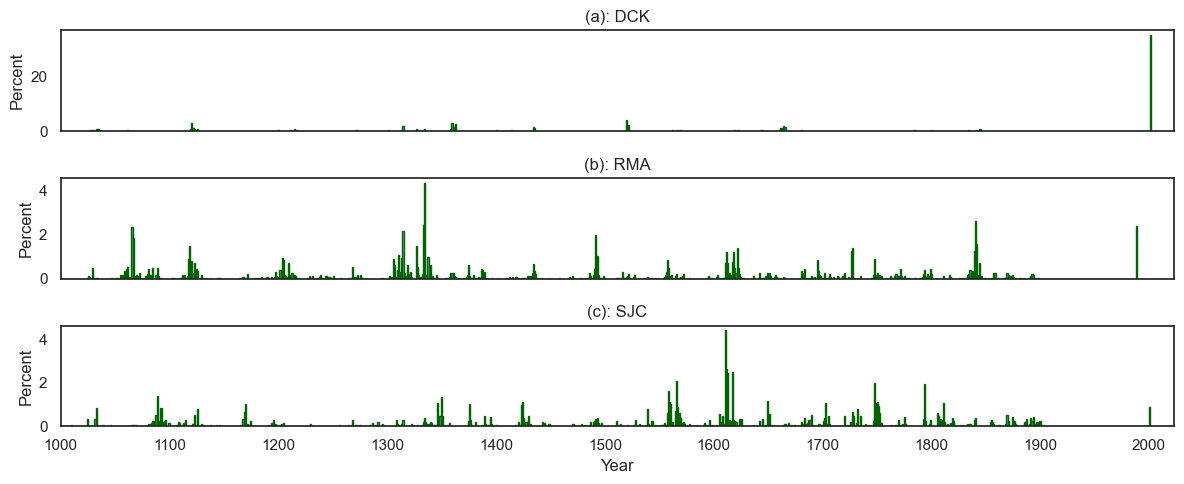

In [686]:
#az.style.use("default")
vari="P"
kind="highest"


if kind == "highest":
    color="darkgreen"
else:
    color="saddlebrown"
roll=10

fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(311)
print("******* DCK *******")
X=get_annual_extrema("DCK",vari,kind=kind,roll=roll,verbose=True)
sns.histplot(X,bins=np.arange(1000,2024),edgecolor=color,stat='percent',ax=ax,linewidth=1)
ax.set_xlim(1000,2023)
ax.set_xticks([])
ax.set_title("(a): DCK")
ax=fig.add_subplot(312)
print("******* RMA *******")
X=get_annual_extrema("RMA",vari,kind=kind,roll=roll,verbose=True)
sns.histplot(X,bins=np.arange(1000,2024),edgecolor=color,stat='percent',ax=ax,linewidth=1)
ax.set_xlim(1000,2023)
ax.set_xticks([])
ax.set_title("(b): RMA")
ax=fig.add_subplot(313)
print("******* SJC *******")
X=get_annual_extrema("SJC",vari,kind=kind,roll=roll,verbose=True)
sns.histplot(X,bins=np.arange(1000,2024),edgecolor=color,stat='percent',ax=ax,linewidth=1)
ax.set_xlim(1000,2023)
ax.set_title("(c): SJC")
ax.set_xticks(np.arange(1000,2100,100))
ax.set_xlabel("Year")
plt.tight_layout()
#plt.savefig("../RESULTS/FIGS/WettestDecadeEver.pdf")

******* DCK *******


/var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/ipykernel_25345/1872963366.py:20: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  X=X.rolling(time=roll,center=False).mean(dim="time")


Most likely lowest P [1940. 1010. 1424. 1864. 1108. 1509. 1868. 1863. 1009. 1824. 1151. 1153.
 1107. 1092. 1457. 1482. 1855. 1856. 1149. 1154. 1579. 1689. 1382. 1481.
 1496.]
10 lowest D  [1864. 1865. 1424. 1941. 1940. 1108. 1106. 1107. 1863. 1010. 1868. 1866.
 1425. 1942. 1105. 1151. 1011. 1856. 1869. 1509. 1423. 1824. 1867. 1009.
 1587.]
probability [88.525  0.425  0.4    0.4    0.275  0.25   0.25   0.2    0.175  0.175
  0.175  0.15   0.15   0.15   0.15   0.15   0.15   0.125  0.125  0.125
  0.125  0.125  0.1    0.1    0.1  ]
******* RMA *******


/var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/ipykernel_25345/1872963366.py:34: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['year']'. Passing the 'dim' kwarg to reduction operations has no effect.
  DTest=DTest.rolling(year=roll).mean(dim="year")
/var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/ipykernel_25345/1872963366.py:20: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  X=X.rolling(time=roll,center=False).mean(dim="time")


Most likely lowest P [1905. 1904. 1959. 1151. 1585. 1782. 1587. 1285. 1099. 1044. 1158. 1781.
 1737. 1254. 1632. 1140. 1671. 1880. 1592. 1014. 1586. 1827. 1757. 1286.
 1631.]
10 lowest D  [1585. 1587. 1782. 1586. 1155. 1151. 1154. 1158. 1588. 1156. 1157. 1152.
 1153. 1285. 1781. 1592. 1584. 1159. 1286. 1099. 1737. 1591. 1590. 1282.
 1902.]
probability [4.625 2.425 1.55  1.45  1.225 1.175 1.075 0.95  0.9   0.825 0.8   0.775
 0.75  0.75  0.725 0.725 0.7   0.7   0.675 0.65  0.65  0.6   0.575 0.575
 0.575]
******* SJC *******


/var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/ipykernel_25345/1872963366.py:34: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['year']'. Passing the 'dim' kwarg to reduction operations has no effect.
  DTest=DTest.rolling(year=roll).mean(dim="year")
/var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/ipykernel_25345/1872963366.py:20: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  X=X.rolling(time=roll,center=False).mean(dim="time")


Most likely lowest P [1933. 1177. 1783. 1179. 1580. 1301. 1239. 1180. 1074. 1218. 1075. 1459.
 1222. 1786. 1073. 1581. 1152. 1434. 1850. 1506. 1784. 1305. 1710. 1135.
 1865.]
10 lowest D  [1179. 1180. 1177. 1301. 1936. 1935. 1783. 1239. 1075. 1580. 1218. 1937.
 1850. 1183. 1178. 1934. 1994. 1784. 1933. 1222. 1074. 1184. 1785. 1849.
 1185.]
probability [63.45   0.525  0.45   0.45   0.425  0.4    0.4    0.35   0.35   0.325
  0.325  0.325  0.3    0.275  0.275  0.275  0.275  0.275  0.275  0.25
  0.25   0.25   0.25   0.25   0.25 ]


/var/folders/l8/1gztm4113nxdtdj6k7cd03b40000gp/T/ipykernel_25345/1872963366.py:34: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['year']'. Passing the 'dim' kwarg to reduction operations has no effect.
  DTest=DTest.rolling(year=roll).mean(dim="year")


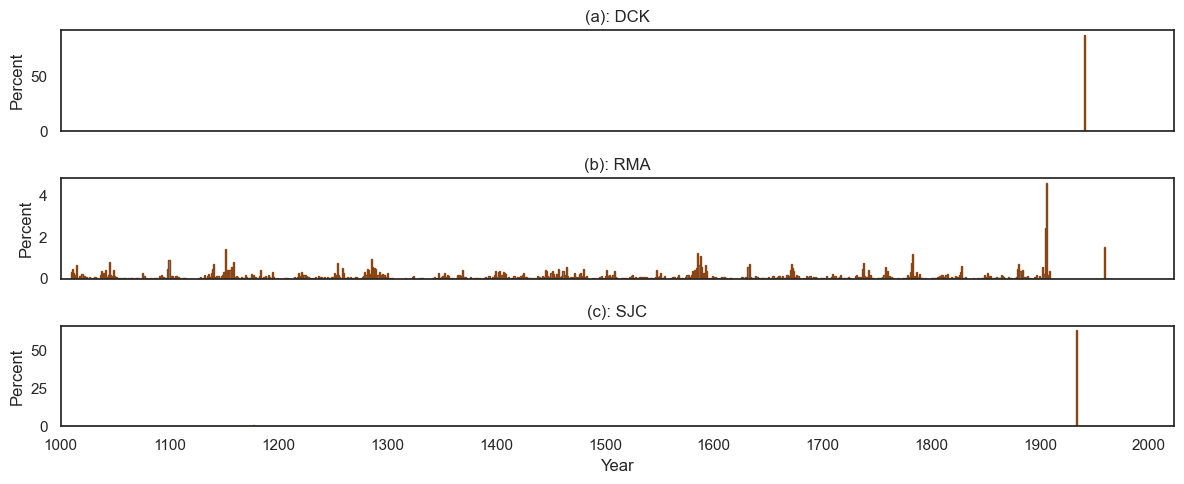

In [775]:
#az.style.use("default")
vari="P"
kind="lowest"


if kind == "highest":
    color="darkgreen"
else:
    color="saddlebrown"
roll=10

fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(311)
print("******* DCK *******")
X=get_extrema("DCK",vari,kind=kind,roll=roll,verbose=True)
sns.histplot(X,bins=np.arange(1000,2024),edgecolor=color,stat='percent',ax=ax,linewidth=1)
ax.set_xlim(1000,2023)
ax.set_xticks([])
ax.set_title("(a): DCK")
ax=fig.add_subplot(312)
print("******* RMA *******")
X=get_extrema("RMA",vari,kind=kind,roll=roll,verbose=True)
sns.histplot(X,bins=np.arange(1000,2024),edgecolor=color,stat='percent',ax=ax,linewidth=1)
ax.set_xlim(1000,2023)
ax.set_xticks([])
ax.set_title("(b): RMA")
ax=fig.add_subplot(313)
print("******* SJC *******")
X=get_extrema("SJC",vari,kind=kind,roll=roll,verbose=True)
sns.histplot(X,bins=np.arange(1000,2024),edgecolor=color,stat='percent',ax=ax,linewidth=1)
ax.set_xlim(1000,2023)
ax.set_title("(c): SJC")
ax.set_xticks(np.arange(1000,2100,100))
ax.set_xlabel("Year")
plt.tight_layout()
#plt.savefig("../RESULTS/FIGS/WettestDecadeEver.pdf")

# PDSI Model
## Priors
\begin{eqnarray}
\gamma \sim N(0,1)\\
F = \gamma^T G \\
\ell \sim N(0,1) \\
\Sigma \sim LKJ(1)  \\
\sigma \sim HalfNormal(1)
\end{eqnarray}
## Model
\begin{eqnarray}
M_{obs}(t) \sim MN(F(t)+VAR(t),\Sigma) \\
VAR(t) = \sum_{i=1}^{nlag} \ell_i M(t+1)\\
D(t) \sim N(\rho D(t+1) + \beta^T M ,\sigma)
\end{eqnarray}
Bayes step:
\begin{equation}
P(M|D) = \frac{P(D|M) P(M)}{P(D)}
\end{equation}

# Correlating P and T
When temperatures are higher, there is less rainfall.  It's hard to tease out the evaporative demand signal from the confounding signal of El Nino.

/Users/kmarvel/anaconda3/envs/pymc_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kmarvel/anaconda3/envs/pymc_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


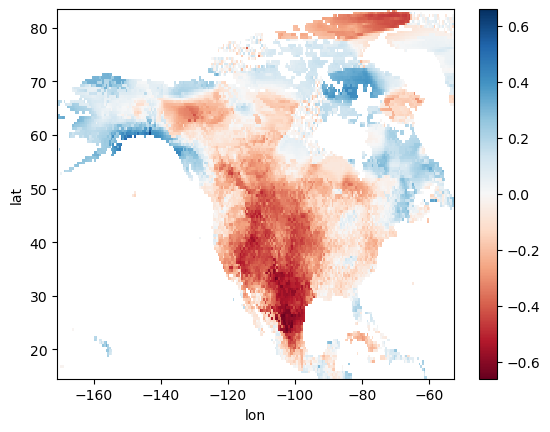

In [10]:
xr.corr(z_train.sel(variable="T"),z_train.sel(variable="P"),dim="time").plot(cmap=cm.RdBu)

In [11]:
# the correlation patterns are themselves highly correlated, suggesting that most of the T impact on PDSI is indirect, through its impact on P
float(xr.corr(xr.corr(z_train.sel(variable="T"),z_train.sel(variable="P"),dim="time"),\
xr.corr(z_train.sel(variable="T"),z_train.sel(variable="PDSI"),dim="time"),dim=("lat","lon")))

/Users/kmarvel/anaconda3/envs/pymc_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kmarvel/anaconda3/envs/pymc_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kmarvel/anaconda3/envs/pymc_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kmarvel/anaconda3/envs/pymc_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


0.7806495470597762

# Correlating P and PDSI
more rainfall makes wetter soil moisture (almost) everywhere.

/Users/kmarvel/anaconda3/envs/pymc_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kmarvel/anaconda3/envs/pymc_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


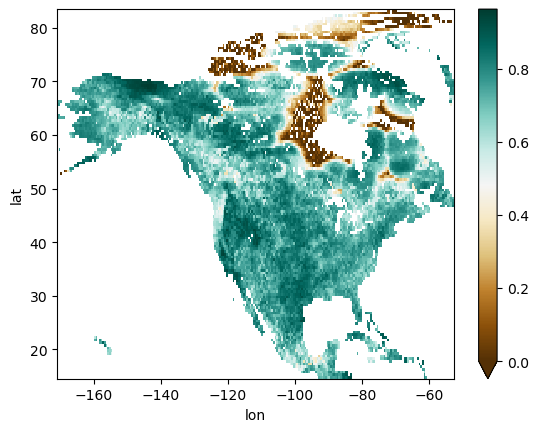

In [12]:
xr.corr(z_train.sel(variable="P"),z_train.sel(variable="PDSI"),dim="time").plot(cmap=cm.BrBG,vmin=0)

In [13]:
from eofs.xarray import Eof

## Temperature covariance
Obviously the overall trend explains most of the temperature variance

In [14]:
Teof=Eof(z_train.sel(variable="T"))
def plot_mode(X,mode):
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    X.eofs().sel(mode=mode).plot()
    plt.subplot(122)
    X.pcs().sel(mode=mode).plot()
    plt.tight_layout()

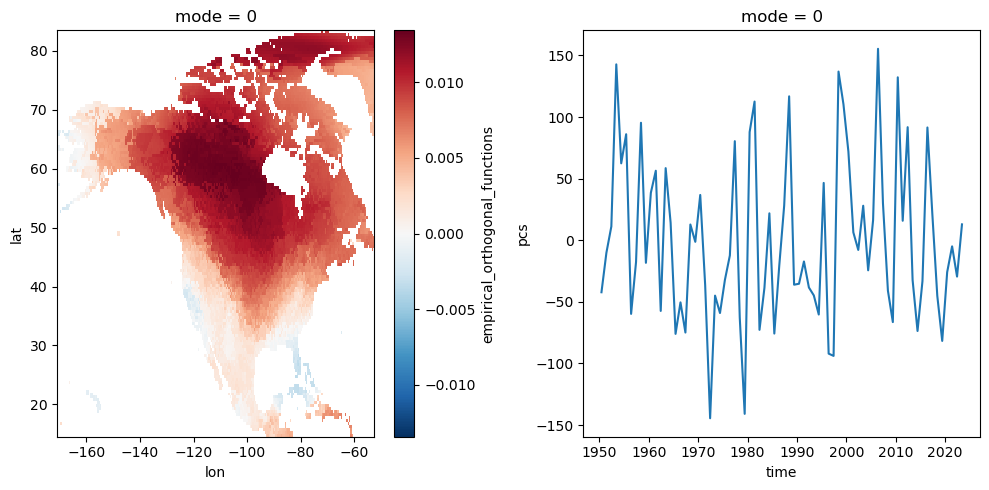

In [15]:
plot_mode(Teof,0)